In [754]:
import pandas as pd
import json
import glob
import os
import collections
import itertools
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

%matplotlib inline

In [769]:
mpl.rcParams['ytick.labelsize'] = 10

In [104]:
encel = ["C00001","C00011","C00237","C00282","C00067","C00132","C06548","C00469","C00283","C00014","C00697","C01326","C01438","C01548","C06547","C11505","C20783","C01407"]


In [105]:
def read_formatted_jsons_streamlined(INDIR,encel):

    list_of_dicts = list()
    
    for domain in os.listdir(INDIR):
        for org in os.listdir(os.path.join(INDIR,domain)):
            for fname in glob.glob(os.path.join(INDIR,domain,org,"*.json")):
        
                d = dict()
        
                with open(fname) as f:
                    datajson = json.load(f)   
                
                d["seed"] = os.path.basename(fname).strip(".json")
                d["org_id"] = org
                d["domain"] = domain
                d["path"] = fname
                d["n_generations"] = len(datajson["generations"]) #.keys())
#                 print datajson["generations"].keys()
#                 break

                ## These should be counted
                d["network_compounds"] = datajson["stats"]["scope_compounds"]
                d["network_reactions"] = datajson["stats"]["scope_reactions"]
                d["seed_compounds"] = datajson["stats"]["scope_seeds"]
                d["seed_compounds_on_enceladus"] = list(set(d["seed_compounds"]) & set(encel))
                d["target_compounds"] = datajson["stats"]["scope_targets"]
                d["target_compounds_in_seeds"] = list(set(d["seed_compounds"]) & set(d["target_compounds"]))
                d["scope_compounds"] = datajson["generations"][str(d["n_generations"])]["compounds_cumulative"]
                d["scope_reactions"] = datajson["generations"][str(d["n_generations"])]["reactions_cumulative"]

                list_of_dicts.append(d)

    return pd.DataFrame(list_of_dicts)

In [106]:
INDIR = "../results/formatted/min_seeds_partial/"

df = read_formatted_jsons_streamlined(INDIR,encel)

### Add `n` columns

In [107]:
def add_n_to_cols(df,cols_to_count):
    
    for col in cols_to_count:
        df["n_"+col] = df[col].str.len() 
    
    return # I don't think I need to return here?

In [108]:
cols_to_count = ["network_compounds",
                "network_reactions",
                "seed_compounds",
                "seed_compounds_on_enceladus",
                "target_compounds",
                "target_compounds_in_seeds",
                "scope_compounds",
                "scope_reactions"]
add_n_to_cols(df,cols_to_count) ## This updates the df in-place

### Add data on mean molecular weights and percent of compounds that don't have weights

Adding molec weight data

In [163]:
kegg_compounds = load_json("../kegg/2018-09-25/compound.json")

In [168]:
kegg_masses = dict()
kegg_weights = dict()

cdir = "../kegg/2018-09-25/compound/"
for fname in os.listdir(cdir):
    cjson = load_json(cdir+fname)
    kegg_masses[cjson[0]['entry_id']] = float(cjson[0]['exact_mass'])
    kegg_weights[cjson[0]['entry_id']] = float(cjson[0]['mol_weight'])

In [169]:
len(kegg_masses)

18181

In [173]:
kegg_masses["C00001"]

18.0106

In [170]:
len(kegg_weights)

18181

In [175]:
print "non-zero masses: ",len([i for i in kegg_masses if kegg_masses[i]!=0])
print "non-zero weights: ",len([i for i in kegg_weights if kegg_weights[i]!=0])

non-zero masses:  16024
non-zero weights:  16024


> Using masses and weights are approximately the same

In [50]:
## sorted_org_cpd_masses = sorted([i for i in org_cpd_masses if i[1]!=0], key=lambda x: x[1], reverse=True)
## org_cpd_zeros = [i for i in org_cpd_masses if i[1]==0]

Add column mean molecular weight of seeds (disregarding compounds of weight 0 or missing)

In [726]:
encel_mean_mol_weight = np.mean([kegg_weights[cpd] for cpd in encel if (cpd in kegg_weights) and (kegg_weights[cpd]>0)]) 

In [727]:
encel_mean_mol_weight

32.489438888888884

> mean molecular weight of compounds on enceladus

#### Add column for mean molec weight

In [189]:
def add_mean_mol_weight_col(row):
    return np.mean([kegg_weights[cpd] for cpd in row["seed_compounds"] if (cpd in kegg_weights) and (kegg_weights[cpd]>0)])         

In [193]:
df["mean_mol_weight_seeds"] = df.apply(add_mean_mol_weight_col, axis=1)

#### Plots for seed size

(array([  4.,  13.,   9.,  11.,  11.,   5.,   3.,   2.,   2.,   4.]),
 array([  9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.]),
 <a list of 10 Patch objects>)

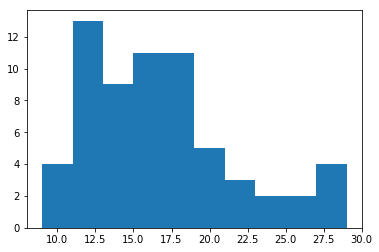

In [258]:
plt.hist(df.groupby("org_id").min()["n_seed_compounds"])

> histogram of number of compounds in seed set (minimum for each org)

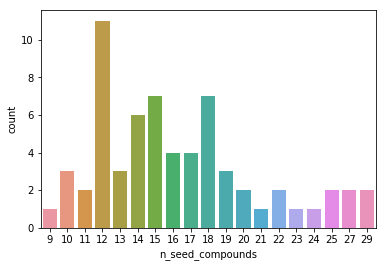

In [221]:
sns.countplot(df.groupby("org_id").min()["n_seed_compounds"])

> countplot of number of compounds in seed set (minimum for each organism)

In [415]:
orgid_domain_dict = dict(df.groupby("org_id").min()["domain"])

In [416]:
len(orgid_domain_dict)

64

In [417]:
len(df)

6400

> What happens when there are multiple mins?

In [709]:
orgid_rank_order = [org for org in df.groupby("org_id").min()["n_seed_compounds"].sort_values().keys()]

In [710]:
color_rank_order = ['blue' if domain=='bacteria' else 'orange' for domain in [orgid_domain_dict[org] for org in orgid_rank_order]]

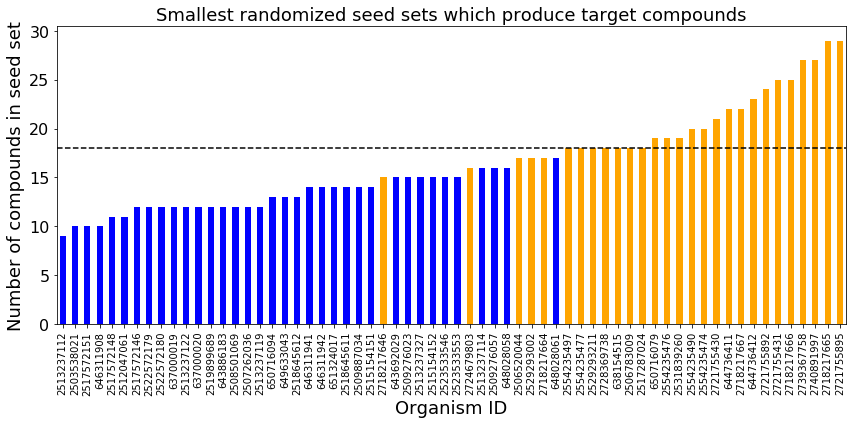

In [728]:
## bacteria=blue, archaea=orange
ax = df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(12,6),color=color_rank_order)
ax.set_title("Smallest randomized seed sets which produce target compounds",fontsize=18)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Organism ID",fontsize=18)
ax.set_ylabel("Number of compounds in seed set",fontsize=18)
ax.axhline(len(encel),c='k',linestyle='--')
plt.tight_layout()

> Ranked histogram of number of compounds in each seed set (blue=bact, orange=arch) (min per organism)

#### Plots for mean molec weight

(array([  1.,   0.,   5.,   9.,   5.,   7.,   9.,  11.,   8.,   9.]),
 array([  97.6646  ,  116.889296,  136.113992,  155.338688,  174.563384,
         193.78808 ,  213.012776,  232.237472,  251.462168,  270.686864,
         289.91156 ]),
 <a list of 10 Patch objects>)

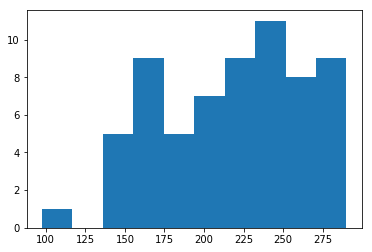

In [261]:
plt.hist(df.groupby("org_id").min()["mean_mol_weight_seeds"])

> histogram of mean molecular weight of each seed set (minimum for each org)

> countplot is not useful here (too many unique mean molecular weights)

In [740]:
orgid_domain_dict = dict(df.groupby("org_id").min()["domain"])

In [741]:
orgid_rank_order = [org for org in df.groupby("org_id").min()["mean_mol_weight_seeds"].sort_values().keys()]

In [742]:
color_rank_order = ['blue' if domain=='bacteria' else 'orange' for domain in [orgid_domain_dict[org] for org in orgid_rank_order]]

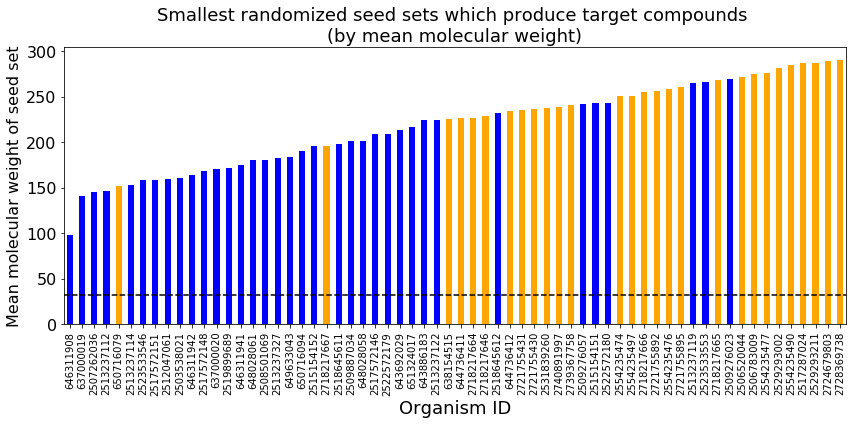

In [743]:
## bacteria=blue, archaea=orange
ax = df.groupby("org_id").min()["mean_mol_weight_seeds"].sort_values().plot(kind="bar",figsize=(12,6),color=color_rank_order)
# ax.set_ylabel("Mean molecular weight of seed set")

ax.set_title("Smallest randomized seed sets which produce target compounds \n(by mean molecular weight)",fontsize=18)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Organism ID",fontsize=18)
ax.set_ylabel("Mean molecular weight of seed set",fontsize=16)
ax.axhline(encel_mean_mol_weight,c='k',linestyle='--')
plt.tight_layout()

> Ranked histogram of mean molec weight of each seed set (blue=bact, orange=arch) (min per organism)

> We know that more complex molecules can replace multiple simple molecules and result in the same scope--so how does mean molec weight and number of seeds correlate?

#### Scatter plot of mean_mol_weight vs. n_seed_compounds

In [737]:
color_order = ['blue' if domain=='bacteria' else 'orange' for domain in df.groupby("org_id").min()["domain"]]

Text(0.5,0,'Number of compounds in seed set')

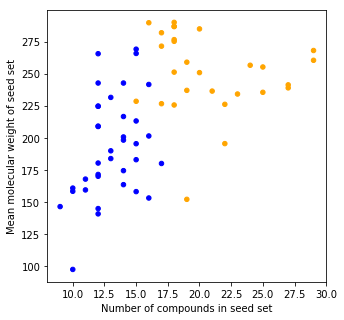

In [281]:
ax = df.groupby("org_id").min().plot(kind="scatter",x="n_seed_compounds",y="mean_mol_weight_seeds",color=color_order,figsize=(5,5))
ax.set_ylabel("Mean molecular weight of seed set")
ax.set_xlabel("Number of compounds in seed set")

> having less seed compounds tends to mean you also have lower mean molecular weight--this is somewhat surprising based on the idea that more simple compounds are required to do the job of less complex ones

> WAIT!! When I do `groupby().min() the columns don't necessarily correspond to the same rows--so how does the above plot look when i look at the mean mol weight of the seeds which have the fewest compounds? (boxplot?)
> Or when I look at the number of compounds in the seed sets with the lowest mean molec weight?

Look for rows with lowest mean molecular weight to replot

In [443]:
df.groupby("org_id")["mean_mol_weight_seeds"].min()

org_id
2503538021    160.963070
2506520044    271.395822
2506783009    275.160829
2507262036    145.023150
2508501069    180.449878
2509276023    269.051857
2509276057    241.591423
2509887034    200.744573
2512047061    159.531418
2513237112    146.561989
2513237114    153.249336
2513237119    265.521700
2513237122    224.771955
2513237327    183.055300
2515154151    242.702308
2515154152    195.495746
2517287024    286.615759
2517572146    208.874100
2517572148    167.952850
2517572151    158.464411
2518645611    198.307122
2518645612    231.525407
2519899689    171.573645
2522572179    209.181386
2522572180    242.710267
2523533546    158.221525
2523533553    265.725236
2529293002    281.831506
2529293211    286.805682
2531839260    237.006135
                 ...    
2554235497    251.188783
2718217646    228.502385
2718217664    226.619675
2718217665    268.022065
2718217666    255.191013
2718217667    195.570588
2721755430    236.440306
2721755431    235.482496
2721755892    256.

In [457]:
df.groupby("org_id")["mean_mol_weight_seeds"].min()["2503538021"]

160.96306999999999

#### Scatter plots that x and y come from same rows

In [452]:
len(df.loc[df.groupby(["org_id"])["mean_mol_weight_seeds"].idxmin()] )

64

In [456]:
len(df.loc[df.groupby("org_id")["n_seed_compounds"].idxmin()])

64

In [448]:
df.loc[df.groupby("org_id")["mean_mol_weight_seeds"].idxmin()].head() ## Returns first occurance of min

,domain,n_generations,network_compounds,network_reactions,org_id,path,scope_compounds,scope_reactions,seed,seed_compounds,...,n_network_compounds,n_network_reactions,n_seed_compounds,n_seed_compounds_on_enceladus,n_target_compounds,n_target_compounds_in_seeds,n_scope_compounds,n_scope_reactions,mean_mol_weight_seeds,percent_of_seeds_without_weights
2857,bacteria,60,"[C01179, C00007, C00299, C00009, C00002, C0134...","[R02521, R01876, R02331, R02433, R08218, R0080...",2503538021,../results/formatted/min_seeds_partial/bacteri...,"[C01179, C00007, C00299, C00009, C00002, C0134...","[R02521, R01876, R02331, R00806, R06983, R0251...",60,"[C00282, C15853, C00856, C00249, C00074, C0017...",...,1533,1363,14,3,57,2,522,635,160.963070,0.285714
8,archaea,56,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R09186, R00934, R0138...",16,"[C00014, C00343, C00039, C00409, C04732, C0014...",...,1198,1044,22,1,55,1,479,565,271.395822,0.181818
180,archaea,3,"[C20518, C00028, C00299, C00009, C00002, C0134...","[R10331, R01876, R02331, R02433, R08218, R0093...",2506783009,../results/formatted/min_seeds_partial/archaea...,"[C01346, C00343, C00011, C00094, C03794, C0024...","[R01083, R00566, R01086, R02021]",81,"[C01346, C00080, C03794, C00249, C19153, C0034...",...,1047,873,23,0,53,5,30,4,275.160829,0.260870
2994,bacteria,3,"[C00422, C00001, C01179, C00007, C00002, C0134...","[R02250, R02521, R02331, R02433, R08218, R0080...",2507262036,../results/formatted/min_seeds_partial/bacteri...,"[C00001, C00007, C00080, C00014, C00011, C0028...","[R00275, R03546, R00131, R07316, R10208, R10079]",94,"[C00014, C00011, C00046, C00249, C00039, C0070...",...,1203,1104,15,2,57,1,23,6,145.023150,0.466667
3070,bacteria,22,"[C00422, C00001, C03117, C00006, C00299, C0000...","[R02250, R03399, R01876, R02331, R08218, R0698...",2508501069,../results/formatted/min_seeds_partial/bacteri...,"[C00001, C00299, C00009, C00002, C00080, C0005...","[R01876, R00959, R05635, R01049, R00765, R0580...",72,"[C00013, C11439, C00148, C00860, C00130, C0433...",...,1127,1030,16,0,60,2,112,120,180.449878,0.437500


In [738]:
color_order = ['blue' if domain=='bacteria' else 'orange' for domain in df.groupby("org_id").min()["domain"]]

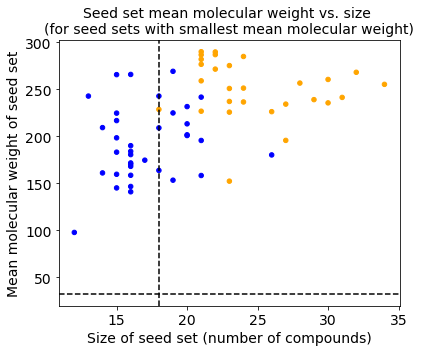

In [748]:
ax = df.loc[df.groupby("org_id")["mean_mol_weight_seeds"].idxmin()].plot(kind="scatter",x="n_seed_compounds",y="mean_mol_weight_seeds",color=color_order,figsize=(6,5))
# ax.set_title("Dependent on molecular weight")
# ax.set_ylabel("Mean molecular weight of seed set")
# ax.set_xlabel("From seed sets with lowest molecular weight")

ax.set_title("Seed set mean molecular weight vs. size \n(for seed sets with smallest mean molecular weight)",fontsize=14)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Size of seed set (number of compounds)",fontsize=14)
ax.set_ylabel("Mean molecular weight of seed set",fontsize=14)
ax.axhline(encel_mean_mol_weight,c='k',linestyle='--')
ax.axvline(len(encel),c='k',linestyle='--')
plt.xticks(fontsize=14)#, rotation=90)
plt.yticks(fontsize=14)#, rotation=90)
plt.tight_layout()

Find _ALL_ rows where value is min, not just first

In [468]:
all_indices = []
for org in df["org_id"].unique():
    minval = df.groupby("org_id")["n_seed_compounds"].min()[org]
    all_indices+=[i for i in df.loc[(df["org_id"]==org) & (df["n_seed_compounds"]==minval)].index]

In [473]:
df.loc[df.index.isin(all_indices)].head() ## This is every row that has a minimum value for "n_seed_compounds"

,domain,n_generations,network_compounds,network_reactions,org_id,path,scope_compounds,scope_reactions,seed,seed_compounds,...,n_network_compounds,n_network_reactions,n_seed_compounds,n_seed_compounds_on_enceladus,n_target_compounds,n_target_compounds_in_seeds,n_scope_compounds,n_scope_reactions,mean_mol_weight_seeds,percent_of_seeds_without_weights
12,archaea,32,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C00016, C00299, C00009, C00002, C01346, C0006...","[R01876, R02331, R01388, R00143, R00078, R0187...",2,"[C00016, C00343, C01144, C00039, C04332, C0036...",...,1198,1044,17,2,55,5,301,353,365.602785,0.235294
195,archaea,28,"[C20518, C00028, C00299, C00009, C00002, C0134...","[R10331, R01876, R02331, R02433, R08218, R0093...",2506783009,../results/formatted/min_seeds_partial/archaea...,"[C20518, C00299, C00009, C00002, C01346, C0002...","[R01876, R02331, R00934, R01859, R01072, R0187...",95,"[C00019, C00249, C00039, C00342, C00082, C0036...",...,1047,873,18,0,53,6,386,437,367.463338,0.277778
204,archaea,53,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2517287024,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R00934, R01388, R0014...",12,"[C00016, C00011, C00046, C05116, C00342, C0036...",...,1178,1027,18,2,55,5,462,543,369.436157,0.222222
206,archaea,56,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2517287024,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R00934, R01388, R0014...",14,"[C00016, C00001, C14818, C00039, C00362, C0013...",...,1178,1027,18,1,55,5,462,546,423.863438,0.277778
236,archaea,47,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2517287024,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R00934, R01388, R0014...",41,"[C05983, C00039, C00143, C00362, C00399, C1552...",...,1178,1027,18,0,55,5,453,532,394.154321,0.222222


In [749]:
color_order = ['blue' if domain=='bacteria' else 'orange' for domain in df.loc[df.index.isin(all_indices)]["domain"]]

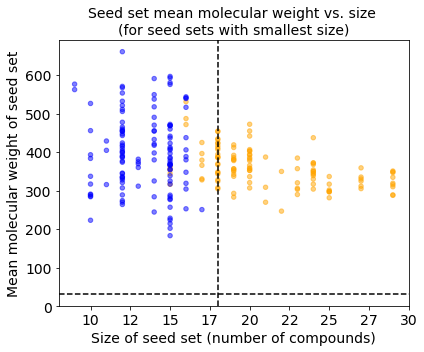

In [755]:
ax = df.loc[df.index.isin(all_indices)].plot(kind="scatter",x="n_seed_compounds",y="mean_mol_weight_seeds",color=color_order,figsize=(6,5),alpha=.5)
# ax.set_title("Dependent on number of compounds in seed set")
# ax.set_ylabel("Mean molecular weight of seed set")
# ax.set_xlabel("From seed sets with least number of compounds")

ax.set_title("Seed set mean molecular weight vs. size \n(for seed sets with smallest size)",fontsize=14)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Size of seed set (number of compounds)",fontsize=14)
ax.set_ylabel("Mean molecular weight of seed set",fontsize=14)
ax.axhline(encel_mean_mol_weight,c='k',linestyle='--')
ax.axvline(len(encel),c='k',linestyle='--')
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xticks(fontsize=14)#, rotation=90)
plt.yticks(fontsize=14)#, rotation=90)
plt.tight_layout()

#### Add column for percent of seeds missing weight information

In [199]:
def add_percent_of_seeds_missing_weights_col(row):
    return len([cpd for cpd in row["seed_compounds"] if (cpd not in kegg_weights) or (kegg_weights[cpd]<=0)])/float(len(row["seed_compounds"]))

In [202]:
df["percent_of_seeds_without_weights"] = df.apply(add_percent_of_seeds_missing_weights_col, axis=1)

Add size of node (bigger if missing less molec weight data)

In [283]:
1-df.groupby("org_id").min()["percent_of_seeds_without_weights"]

org_id
2503538021    0.785714
2506520044    0.913043
2506783009    0.850000
2507262036    0.789474
2508501069    0.777778
2509276023    0.850000
2509276057    0.750000
2509887034    0.833333
2512047061    0.785714
2513237112    0.714286
2513237114    0.842105
2513237119    0.777778
2513237122    0.789474
2513237327    0.736842
2515154151    0.789474
2515154152    0.764706
2517287024    0.884615
2517572146    0.714286
2517572148    0.750000
2517572151    0.750000
2518645611    0.750000
2518645612    0.833333
2519899689    0.812500
2522572179    0.785714
2522572180    0.789474
2523533546    0.777778
2523533553    0.833333
2529293002    0.909091
2529293211    0.900000
2531839260    0.863636
                ...   
2554235497    0.904762
2718217646    0.950000
2718217664    0.960000
2718217665    0.818182
2718217666    0.892857
2718217667    0.888889
2721755430    0.892857
2721755431    0.884615
2721755892    0.840000
2721755895    0.787879
2724679803    0.909091
2728369738    1.000000
2739

In [288]:
[(1-i)*100 for i in df.groupby("org_id").min()["percent_of_seeds_without_weights"]]

[78.57142857142857,
 91.30434782608697,
 85.0,
 78.94736842105263,
 77.77777777777779,
 85.0,
 75.0,
 83.33333333333334,
 78.57142857142857,
 71.42857142857143,
 84.21052631578947,
 77.77777777777779,
 78.94736842105263,
 73.6842105263158,
 78.94736842105263,
 76.47058823529412,
 88.46153846153845,
 71.42857142857143,
 75.0,
 75.0,
 75.0,
 83.33333333333334,
 81.25,
 78.57142857142857,
 78.94736842105263,
 77.77777777777779,
 83.33333333333334,
 90.9090909090909,
 90.0,
 86.36363636363636,
 82.6086956521739,
 91.66666666666666,
 90.9090909090909,
 88.0,
 90.47619047619048,
 95.0,
 96.0,
 81.81818181818181,
 89.28571428571429,
 88.88888888888889,
 89.28571428571429,
 88.46153846153845,
 84.0,
 78.78787878787878,
 90.9090909090909,
 100.0,
 86.20689655172413,
 94.11764705882352,
 75.0,
 80.0,
 86.95652173913044,
 90.9090909090909,
 82.35294117647058,
 88.0,
 88.88888888888889,
 80.0,
 77.27272727272727,
 77.77777777777779,
 85.71428571428572,
 85.0,
 81.25,
 95.45454545454545,
 75.0,
 70

Text(0.5,0,'Number of compounds in seed set')

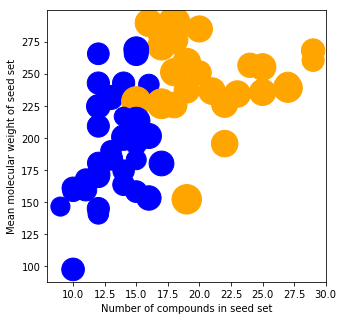

In [294]:
ax = df.groupby("org_id").min().plot(kind="scatter",x="n_seed_compounds",y="mean_mol_weight_seeds",color=color_order,figsize=(5,5)),s=[(1-i)*10) for i in df.groupby("org_id").min()["percent_of_seeds_without_weights"]])
ax.set_ylabel("Mean molecular weight of seed set")
ax.set_xlabel("Number of compounds in seed set")

> This doesn't seem useful, since most organisms have most of their molec weight information

(array([  3.,   7.,  14.,   5.,  10.,   6.,  12.,   3.,   3.,   1.]),
 array([  70.58823529,   73.52941176,   76.47058824,   79.41176471,
          82.35294118,   85.29411765,   88.23529412,   91.17647059,
          94.11764706,   97.05882353,  100.        ]),
 <a list of 10 Patch objects>)

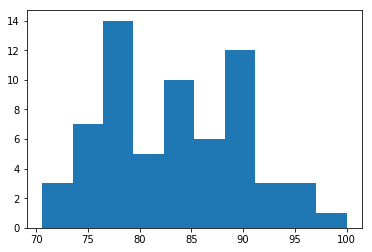

In [295]:
plt.hist([(1-i)*100 for i in df.groupby("org_id").min()["percent_of_seeds_without_weights"]])

> Histogram of % of compounds in seed set that have molecular weight information (minimum seed set per organism)

## Jaccard time

Determine jaccard self-similarity of seeds for every organism

In [355]:
all_orgs_all_seeds = dict()
for org in df["org_id"].unique():
    all_orgs_all_seeds[org] = dict()
    for i,series in df.loc[df["org_id"]==org].iterrows():
        all_orgs_all_seeds[org][series["seed"]] = (set(series["seed_compounds"]))

In [356]:
def calc_jaccard(s1,s2):
    return len(s1 & s2)/float(len(s1 | s2))

In [404]:
def full_org_self_jaccard_calc(all_orgs_all_seeds):
    
    org_domain_dict = dict(df.groupby("org_id").min()["domain"])
    all_key_pairs = list(itertools.product(all_orgs_all_seeds['2517572148'].keys(), repeat=2)) #doesn't matter which org is used here to calc pairs
    
    all_dicts = []
    for org in all_orgs_all_seeds:
                
        for (i,j) in all_key_pairs:
            
            d = dict()
            d["jaccard"] = calc_jaccard(all_orgs_all_seeds[org][i],all_orgs_all_seeds[org][j])
            d["seed1"] = i
            d["seed2"] = j
            d["org_id"] = org
            d["domain"] = org_domain_dict[org]
            all_dicts.append(d)
        
    return all_dicts

In [406]:
all_seeds_jaccard_list = full_org_self_jaccard_calc(all_orgs_all_seeds)

In [407]:
all_seeds_jaccard_df = pd.DataFrame(all_seeds_jaccard_list)

In [409]:
all_seeds_jaccard_df["org_id"].unique()

array(['2517572148', '2506520044', '2728369738', '2721755430',
       '2721755431', '2718217666', '2718217667', '2718217664',
       '2718217665', '2512047061', '2509276057', '2519899689',
       '2523533546', '2507262036', '2531839260', '643692029', '650716094',
       '637000019', '2513237122', '651324017', '2517572151', '2513237327',
       '648028058', '2522572179', '2503538021', '646311941', '646311942',
       '2506783009', '2509887034', '2721755892', '637000020', '2721755895',
       '650716079', '646311908', '2529293211', '2517572146', '638154515',
       '2509276023', '2739367758', '2518645612', '2515154152',
       '2515154151', '2518645611', '2554235474', '2554235477',
       '2554235476', '2554235497', '2508501069', '644736411', '644736412',
       '2554235490', '2517287024', '2523533553', '2513237114', '643886183',
       '2513237112', '648028061', '2718217646', '2513237119', '2724679803',
       '2522572180', '2529293002', '2740891997', '649633043'], dtype=object)

In [408]:
len(all_seeds_jaccard_df)

640000

In [410]:
all_seeds_jaccard_df.loc[all_seeds_jaccard_df["org_id"]=="2517572148"].head()

,domain,jaccard,org_id,seed1,seed2
0,bacteria,1.000000,2517572148,24,24
1,bacteria,0.125000,2517572148,24,25
2,bacteria,0.076923,2517572148,24,26
3,bacteria,0.217391,2517572148,24,27
4,bacteria,0.181818,2517572148,24,20


In [419]:
all_seeds_jaccard_df.groupby("org_id").mean()

,jaccard
org_id,
2503538021,0.120380
2506520044,0.143109
2506783009,0.156575
2507262036,0.117910
2508501069,0.111073
2509276023,0.122039
2509276057,0.124399
2509887034,0.109698
2512047061,0.098529


What does an individual organism's seed set look like?

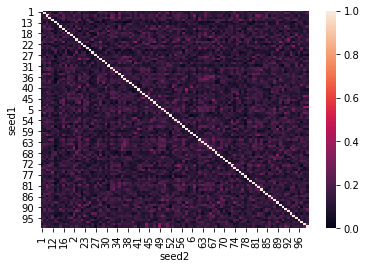

In [435]:
ax = sns.heatmap(all_seeds_jaccard_df.loc[all_seeds_jaccard_df["org_id"]=="2506520044"].pivot("seed1", "seed2", "jaccard"))

> Not very insightful

In [756]:
orgid_domain_dict = dict(df.groupby("org_id").min()["domain"])

In [757]:
orgid_rank_order = [org for org in all_seeds_jaccard_df.groupby("org_id").mean()["jaccard"].sort_values(ascending=False).keys()]

In [758]:
color_rank_order = ['blue' if domain=='bacteria' else 'orange' for domain in [orgid_domain_dict[org] for org in orgid_rank_order]]

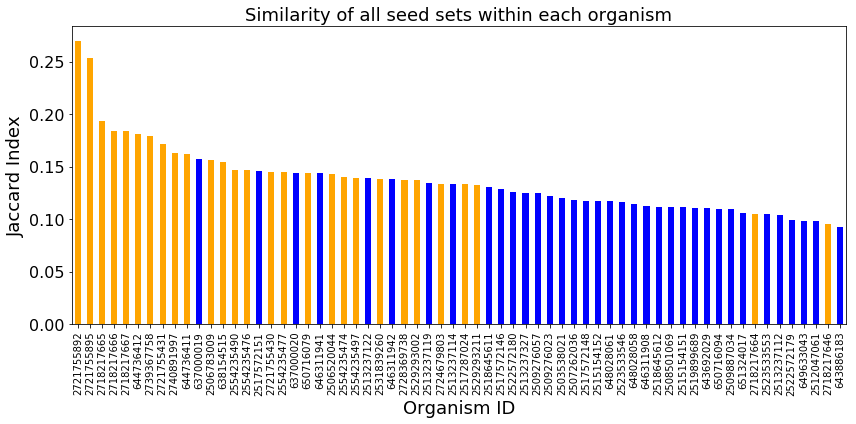

In [761]:
## bacteria=blue, archaea=orange
ax = all_seeds_jaccard_df.groupby("org_id").mean()["jaccard"].sort_values(ascending=False).plot(kind="bar",figsize=(12,6),color=color_rank_order)
ax.set_ylabel("")

ax.set_title("Similarity of all seed sets within each organism",fontsize=18)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Organism ID",fontsize=18)
ax.set_ylabel("Jaccard Index",fontsize=18)
# ax.axhline(encel_mean_mol_weight,c='k',linestyle='--')
# ax.axvline(len(encel),c='k',linestyle='--')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
# plt.xticks(fontsize=14)#, rotation=90)
# plt.yticks(fontsize=14)#, rotation=90)
plt.tight_layout()

> Archaea tend to have more similarity from seed to seed

Calculate union of all seeds for each organism and use to make jaccard similarity accross organisms

In [521]:
## {'2503538021': {'seed': '60'},
##  '2506520044': {'seed': '16'}, ...
dict_of_min_molec_weights = df.loc[df.groupby("org_id")["mean_mol_weight_seeds"].idxmin()][["org_id","seed"]].set_index("org_id").to_dict('index')
dict_of_min_n_seed_compounds = df.loc[df.groupby("org_id")["n_seed_compounds"].idxmin()][["org_id","seed"]].set_index("org_id").to_dict('index')


In [525]:
all_orgs_union_seeds = dict()
all_orgs_min_n_seeds = dict()  ## This just takes the first one it finds
all_orgs_min_weight_seeds = dict()
for org in all_orgs_all_seeds:
    all_orgs_union_seeds[org] = set.union(*all_orgs_all_seeds[org].values())
    all_orgs_min_weight_seeds[org] = all_orgs_all_seeds[org][dict_of_min_molec_weights[org]['seed']]
    all_orgs_min_n_seeds[org] = all_orgs_all_seeds[org][dict_of_min_n_seed_compounds[org]['seed']] ## This just looks at first min it finds

In [529]:
def one_set_per_org_jaccard_calc(all_orgs_dict):
    
    org_domain_dict = dict(df.groupby("org_id").min()["domain"])
    all_key_pairs = list(itertools.product(all_orgs_dict.keys(), repeat=2)) #doesn't matter which org is used here to calc pairs
    
    all_dicts = []
                
    for (org1,org2) in all_key_pairs:

        d = dict()
        d["jaccard"] = calc_jaccard(all_orgs_dict[org1],all_orgs_dict[org2])
        d["org1"] = org1
        d["org2"] = org2
        d["domain1"] = org_domain_dict[org1]
        d["domain2"] = org_domain_dict[org2]
        all_dicts.append(d)
        
    return pd.DataFrame(all_dicts)

In [530]:
j_union_df = one_set_per_org_jaccard_calc(all_orgs_union_seeds)
j_weightmin_df = one_set_per_org_jaccard_calc(all_orgs_min_n_seeds)
j_nmin_df = one_set_per_org_jaccard_calc(all_orgs_min_weight_seeds)

In [531]:
j_union_df.head()

,domain1,domain2,jaccard,org1,org2
0,bacteria,bacteria,1.000000,2517572148,2517572148
1,bacteria,bacteria,0.276636,2517572148,643692029
2,bacteria,bacteria,0.368870,2517572148,637000019
3,bacteria,archaea,0.208494,2517572148,2721755430
4,bacteria,archaea,0.188377,2517572148,2721755431


Calculate union of all seeds for each organism and use to make jaccard similarity accross organisms

In [597]:
# plt.figure(figsize=(15,15))
# ax = sns.heatmap(j_union_df.pivot("org1", "org2", "jaccard"),square=True)

In [762]:
lut = {"bacteria":"blue","archaea":"orange"}

In [763]:
orgid_domain_dict = dict(df.groupby("org_id").min()["domain"])

In [764]:
series_color_map = pd.Series(orgid_domain_dict).map(lut)

In [771]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

<Figure size 1080x1080 with 0 Axes>

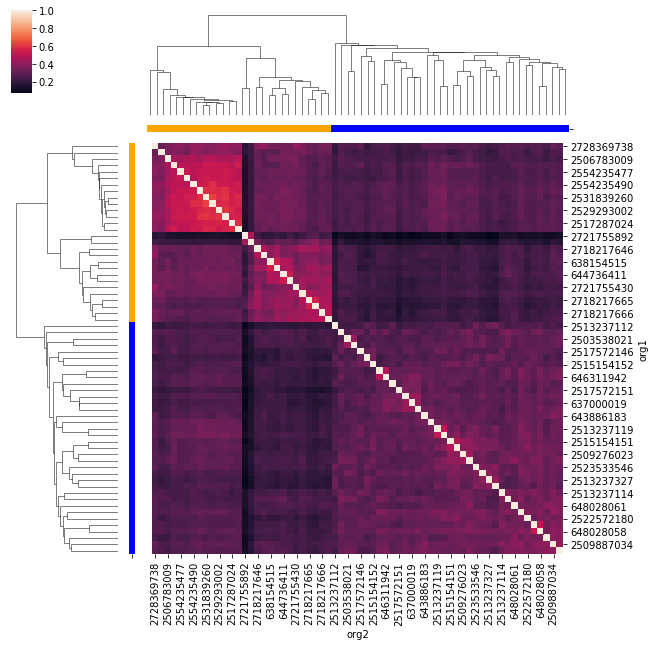

In [773]:
plt.figure(figsize=(15,15))
ax = sns.clustermap(j_union_df.pivot("org1", "org2", "jaccard"),square=True, metric="correlation",row_colors = series_color_map, col_colors=series_color_map) # 
# plt.xticks(fontsize=14)#, rotation=90)
# plt.yticks(fontsize=8)#, rotation=90)
# plt.tight_layout()

> It's somewhat expected that these cluster, because the union of their seed sets should be representative of their overall biochemistry

Calculate minimum of all seeds for each organism and use to make jaccard similarity accross organisms

<Figure size 1080x1080 with 0 Axes>

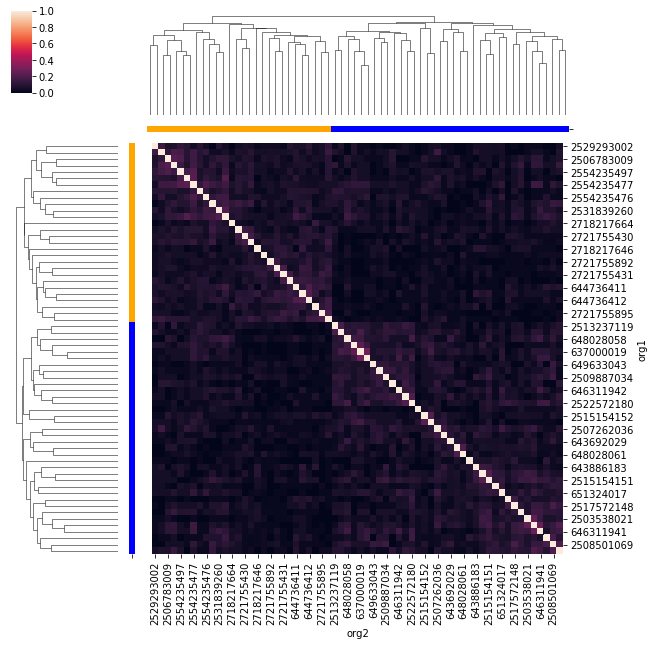

In [600]:
plt.figure(figsize=(15,15))
ax = sns.clustermap(j_nmin_df.pivot("org1", "org2", "jaccard"),square=True, metric="correlation",row_colors = series_color_map, col_colors=series_color_map) # 

> It's less expected that these cluster, because the minimum seed sets are less correllated. Nevertheless the archaea and bacteria cluster out


Calculate minimum of all seeds for each organism by weight

<Figure size 1080x1080 with 0 Axes>

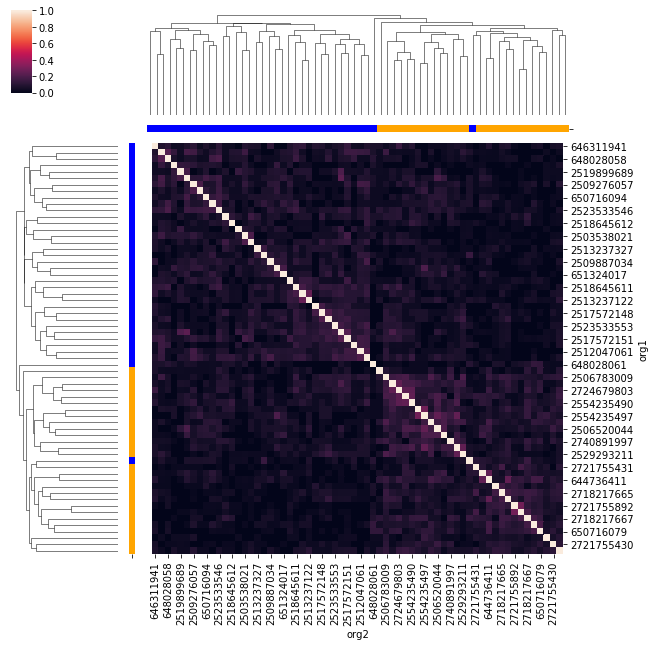

In [774]:
plt.figure(figsize=(15,15))
ax = sns.clustermap(j_weightmin_df.pivot("org1", "org2", "jaccard"),square=True, metric="correlation",row_colors = series_color_map, col_colors=series_color_map) # 

#### Look at weight of a compound and how rare it is in the seeds

In [ ]:
[kegg_weights[cpd] for cpd in row["seed_compounds"] if (cpd in kegg_weights) and (kegg_weights[cpd]>0)])  

Can I add data on which are most common in archaea vs bacteria?

Most commmon in archaea

In [615]:
most_common_cpds_archaea = collections.Counter([cpd for row in df.loc[df["domain"]=="archaea"].index for cpd in df.loc[df["domain"]=="archaea"]["seed_compounds"][row]]).most_common()

In [616]:
most_common_cpds_bacteria = collections.Counter([cpd for row in df.loc[df["domain"]=="bacteria"].index for cpd in df.loc[df["domain"]=="bacteria"]["seed_compounds"][row]]).most_common()

In [623]:
most_common_cpds_archaea_dict = dict()
for k,v in most_common_cpds_archaea:
    most_common_cpds_archaea_dict[k] = v
    
most_common_cpds_bacteria_dict = dict()
for k,v in most_common_cpds_bacteria:
    most_common_cpds_bacteria_dict[k] = v

In [653]:
most_common_for_plot_colors = []
cpds_for_plot = []
nseeds_for_plot = []
weights_for_plot = []
n_in_archaea = []
n_in_bacteria = []
for cpd,nseeds in collections.Counter([cpd for row in range(len(df)) for cpd in df["seed_compounds"][row]]).most_common():
    
    if (cpd in kegg_weights):
        weight = kegg_weights[cpd]
    else:
        weight = 0.0
        
    if (cpd in most_common_cpds_archaea_dict) and (cpd in most_common_cpds_bacteria_dict):
        if most_common_cpds_archaea_dict[cpd] > most_common_cpds_bacteria_dict[cpd]:
            most_common_for_plot_colors.append("orange")
        elif most_common_cpds_archaea_dict[cpd] < most_common_cpds_bacteria_dict[cpd]:
            most_common_for_plot_colors.append("blue")
        else:
            most_common_for_plot_colors.append("black")
    elif cpd not in most_common_cpds_archaea_dict:
         most_common_for_plot_colors.append("blue")
    elif cpd not in most_common_cpds_bacteria_dict:
         most_common_for_plot_colors.append("orange")
    else: 
        most_common_for_plot_colors.append("black")
    
    cpds_for_plot.append(cpd)
    nseeds_for_plot.append(nseeds)
    weights_for_plot.append(weight)
    if cpd in most_common_cpds_archaea_dict:
        n_in_archaea.append(most_common_cpds_archaea_dict[cpd])
    else:
        n_in_archaea.append(0)
    if cpd in most_common_cpds_bacteria_dict:
        n_in_bacteria.append(most_common_cpds_bacteria_dict[cpd])
    else:
        n_in_bacteria.append(0)

In [658]:
cpd_df = pd.DataFrame({"cpd":cpds_for_plot, "nseeds_present":nseeds_for_plot, "mol_weight":weights_for_plot, "n_archaea":n_in_archaea, "n_bacteria":n_in_bacteria,"colors":most_common_for_plot_colors})

In [659]:
cpd_df.head()

,colors,cpd,mol_weight,n_archaea,n_bacteria,nseeds_present
0,blue,C00399,0.000,952,1288,2240
1,blue,C00390,0.000,948,1136,2084
2,blue,C14818,55.845,650,1424,2074
3,blue,C04088,0.000,0,1736,1736
4,blue,C16221,0.000,0,1719,1719


Text(0.5,0,'Rarity \n (number of seeds in which compound is present)')

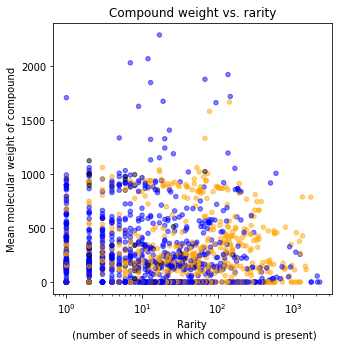

In [660]:
ax = cpd_df.plot(kind="scatter",x="nseeds_present",y="mol_weight",color=most_common_for_plot_colors,figsize=(5,5),alpha=.5)
ax.set_xscale("log")
ax.set_title("Compound weight vs. rarity")
ax.set_ylabel("Mean molecular weight of compound")
ax.set_xlabel("Rarity \n (number of seeds in which compound is present)")

Grouped bar plots

In [775]:
grouped_df = cpd_df[["cpd","n_archaea","n_bacteria"]]#,"colors"]]

Text(0,0.5,'Number of seeds compound is present')

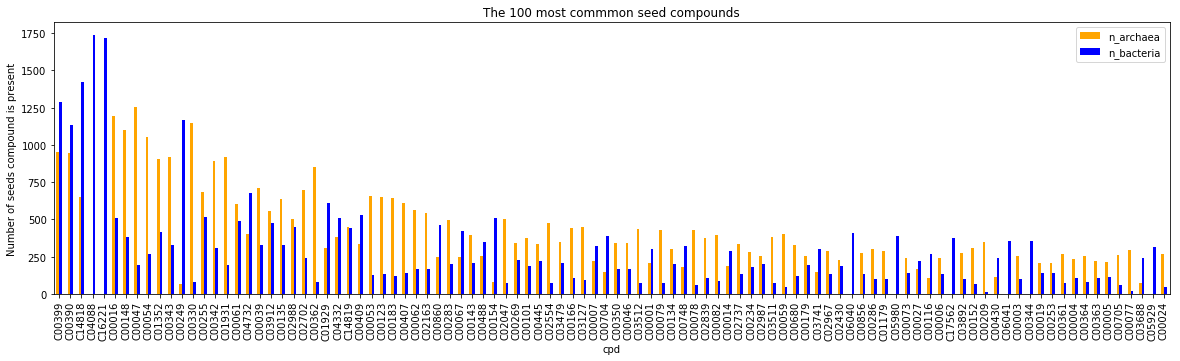

In [679]:
ax = grouped_df[:100].set_index("cpd").plot(kind="bar",figsize=(20,5),color=["orange","blue"])
ax.set_title("The 100 most commmon seed compounds")
ax.set_ylabel("Number of seeds compound is present")

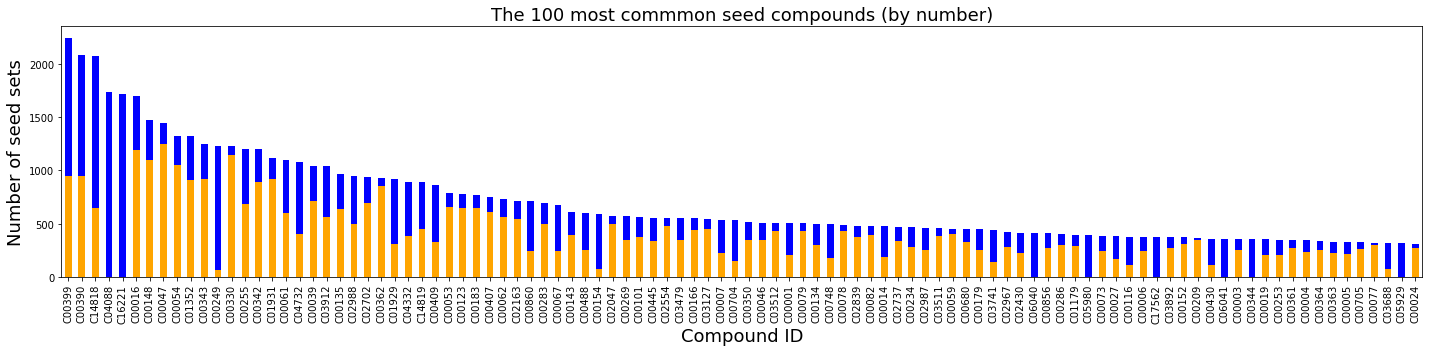

In [776]:
ax = grouped_df[:100].set_index("cpd").plot(kind="bar",stacked="true",figsize=(20,5),color=["orange","blue"],legend=False)

ax.set_title("The 100 most commmon seed compounds (by number)",fontsize=18)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Compound ID",fontsize=18)
ax.set_ylabel("Number of seed sets",fontsize=18)
# ax.axhline(encel_mean_mol_weight,c='k',linestyle='--')
# ax.axvline(len(encel),c='k',linestyle='--')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
# plt.xticks(fontsize=14)#, rotation=90)
# plt.yticks(fontsize=14)#, rotation=90)
plt.tight_layout()

In [778]:
weight_grouped_df = cpd_df[["cpd","mol_weight","colors"]]

In [779]:
colors = weight_grouped_df.pop("colors")

In [780]:
# [i for i in colors[:100]]

In [781]:
# color_rank_order

In [782]:
# ax = weight_grouped_df[:100].set_index("cpd").plot(kind="bar",figsize=(20,5),color="black")#,color=[i for i in colors[:100]])
# ax.set_title("The molecular weight of the 100 most commmon seed compounds")
# ax.set_ylabel("Molecular weight \n (Missing values have weight of zero)")

In [783]:
weight_grouped_df = cpd_df[["cpd","mol_weight","colors"]]

In [784]:
# weight_grouped_df[:15]

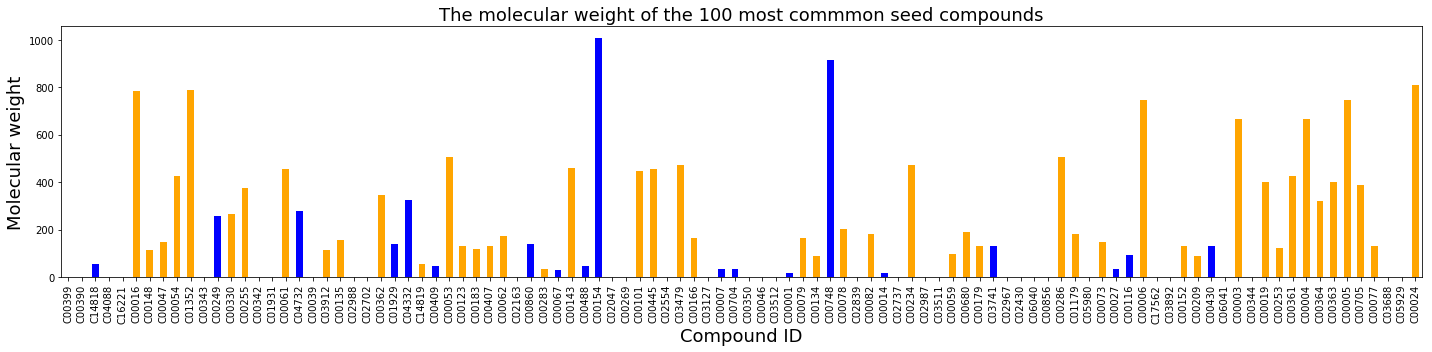

In [787]:
ax = weight_grouped_df[:100].set_index("cpd").plot(y="mol_weight",kind="bar",figsize=(20,5),color=[i for i in colors[:100]],legend=False)
# ax.set_title("The molecular weight of the 100 most commmon seed compounds")
# ax.set_ylabel("Molecular weight \n (Missing values have weight of zero)")

ax.set_title("The molecular weight of the 100 most commmon seed compounds",fontsize=18)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel("Compound ID",fontsize=18)
ax.set_ylabel("Molecular weight",fontsize=18)# \n (Missing values have weight of zero)",fontsize=16)
# ax.axhline(encel_mean_mol_weight,c='k',linestyle='--')
# ax.axvline(len(encel),c='k',linestyle='--')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
# plt.xticks(fontsize=14)#, rotation=90)
# plt.yticks(fontsize=14)#, rotation=90)
plt.tight_layout()

In [162]:
df.head()

,domain,n_generations,network_compounds,network_reactions,org_id,path,scope_compounds,scope_reactions,seed,seed_compounds,...,target_compounds,target_compounds_in_seeds,n_network_compounds,n_network_reactions,n_seed_compounds,n_seed_compounds_on_enceladus,n_target_compounds,n_target_compounds_in_seeds,n_scope_compounds,n_scope_reactions
0,archaea,49,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R09186, R00934, R0138...",1,"[C00016, C00343, C14818, C19153, C00079, C0014...",...,"[C00016, C00002, C00065, C00004, C00003, C0002...","[C00399, C00079, C00016, C00148, C00144, C0005...",1198,1044,21,1,55,8,475,553
1,archaea,51,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R09186, R00934, R0138...",10,"[C00167, C19153, C00342, C00430, C00209, C0017...",...,"[C00016, C00002, C00065, C00004, C00003, C0002...","[C00047, C00148, C00234, C00399]",1198,1044,22,0,55,4,483,562
2,archaea,44,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R09186, R00934, R0138...",100,"[C00343, C14818, C00286, C00111, C00143, C0036...",...,"[C00016, C00002, C00065, C00004, C00003, C0002...","[C00047, C00148, C00286, C00362, C00350]",1198,1044,22,1,55,5,472,554
3,archaea,42,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R09186, R0093...",11,"[C00028, C00046, C00342, C00209, C19779, C0106...",...,"[C00016, C00002, C00065, C00004, C00003, C0002...","[C00148, C00047]",1198,1044,21,0,55,2,503,593
4,archaea,48,"[C01832, C00016, C20518, C00028, C00299, C0000...","[R03857, R10331, R01876, R02331, R02433, R0821...",2506520044,../results/formatted/min_seeds_partial/archaea...,"[C01832, C00016, C20518, C00299, C00009, C0000...","[R03857, R01876, R02331, R09186, R00934, R0138...",12,"[C00016, C00001, C00343, C04677, C00037, C1915...",...,"[C00016, C00002, C00065, C00004, C00003, C0002...","[C00037, C00148, C00362, C00399, C00016]",1198,1044,22,2,55,5,490,569


In [110]:
len(df)

6400

#### Thought: First of all, this would be interesting to repeat seed experiments where I I keep them in mass decreasing order

How many enceladus compounds show up in the seed sets here? Only 2 seed sets use 4 of these compounds.

In [87]:
collections.Counter([len(df["seed_compounds_on_enceladus"][row]) for row in range(len(df))]).most_common()

[(0, 4163), (1, 1860), (2, 351), (3, 24), (4, 2)]

What are these seed sets which use 4 of these compounds?

In [94]:
paths_of_4_encel = [df["path"][row] for row in range(len(df)) if len(df["seed_compounds_on_enceladus"][row])==4]

How big are their seed sets? 28 and 20

In [98]:
[len(i) for i in df.loc[df["path"].isin(paths_of_4_encel)]["seed_compounds"]]

[28, 20]

How many compounds are in each seed set? Anywhere from 9 (uncommon) to 39 (also uncommon). The most common size is 16.

In [85]:
max(collections.Counter([len(df["seed_compounds"][row]) for row in range(len(df))]))

39

In [86]:
min(collections.Counter([len(df["seed_compounds"][row]) for row in range(len(df))]))

9

In [84]:
collections.Counter([len(df["seed_compounds"][row]) for row in range(len(df))]).most_common()

[(16, 577),
 (17, 530),
 (15, 515),
 (20, 498),
 (18, 475),
 (19, 471),
 (21, 453),
 (14, 417),
 (22, 377),
 (13, 314),
 (23, 272),
 (24, 207),
 (12, 160),
 (26, 159),
 (25, 150),
 (27, 145),
 (28, 107),
 (29, 99),
 (30, 90),
 (31, 84),
 (32, 76),
 (33, 59),
 (11, 52),
 (34, 37),
 (35, 22),
 (10, 18),
 (36, 16),
 (37, 11),
 (38, 6),
 (9, 2),
 (39, 1)]

How many unique compounds are involved in seeds? 1527

In [78]:
len(set([cpd for row in range(len(df)) for cpd in df["seed_compounds"][row]]))

1527

Which ones are involved in the most seeds? Coenzymes

In [789]:
collections.Counter([cpd for row in range(len(df)) for cpd in df["seed_compounds"][row]]).most_common()[:100]

[(u'C00399', 2240),
 (u'C00390', 2084),
 (u'C14818', 2074),
 (u'C04088', 1736),
 (u'C16221', 1719),
 (u'C00016', 1702),
 (u'C00148', 1478),
 (u'C00047', 1449),
 (u'C00054', 1325),
 (u'C01352', 1322),
 (u'C00343', 1246),
 (u'C00249', 1233),
 (u'C00330', 1229),
 (u'C00255', 1204),
 (u'C00342', 1202),
 (u'C01931', 1116),
 (u'C00061', 1096),
 (u'C04732', 1079),
 (u'C00039', 1045),
 (u'C03912', 1038),
 (u'C00135', 964),
 (u'C02988', 950),
 (u'C02702', 937),
 (u'C00362', 932),
 (u'C01929', 920),
 (u'C04332', 894),
 (u'C14819', 891),
 (u'C00409', 863),
 (u'C00053', 788),
 (u'C00123', 783),
 (u'C00183', 768),
 (u'C00407', 749),
 (u'C00062', 732),
 (u'C02163', 716),
 (u'C00860', 709),
 (u'C00283', 699),
 (u'C00067', 672),
 (u'C00143', 607),
 (u'C00488', 602),
 (u'C00154', 590),
 (u'C02047', 573),
 (u'C00269', 570),
 (u'C00101', 565),
 (u'C00445', 558),
 (u'C02554', 555),
 (u'C03479', 555),
 (u'C00166', 552),
 (u'C03127', 546),
 (u'C00007', 540),
 (u'C00704', 537),
 (u'C00350', 515),
 (u'C00046'

In [67]:
collections.Counter(df["seed_compounds"])

TypeError: unhashable type: 'list'

In [68]:
flights = sns.load_dataset("flights")


In [69]:
flights

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


In [70]:
flights = flights.pivot("month", "year", "passengers")


In [71]:
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


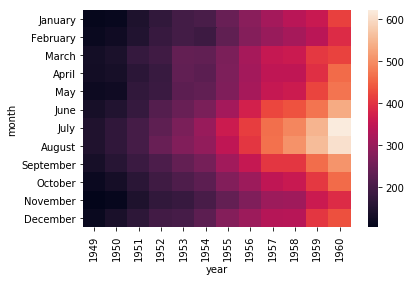

In [72]:
ax = sns.heatmap(flights)

In [27]:
td = {1: 5, 2: 6, 89: 1000}

In [29]:
max(td.keys())

89

### Main

In [8]:
cpds_to_tag = []

INDIR = "../results/formatted/ph_edge_jsons/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [9]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C00014, C00011, C00697, C00067, C0046...","[C00282, C00237, C00014, C00011, C00067, C0069...","[R10092, R00131, R00602, R00132]","[R00131, R00132, R00602, R10092]",[],[],10,10,4,4,0,0,2506520044,archaea
2,"[C00080, C00001, C00014, C00288, C00011, C0069...","[C00080, C00288, C00086, C00027, C01353]","[R10092, R06154, R00131, R00602, R00132, R00009]","[R06154, R00009]",[],[],15,5,6,2,0,0,2506520044,archaea
3,"[C00007, C00080, C00001, C00014, C00288, C0001...","[C00007, C00218]","[R10092, R06154, R00275, R00131, R00602, R0013...",[R00275],[],[],17,2,7,1,0,0,2506520044,archaea
4,"[C00007, C00080, C00001, C00014, C00288, C0001...",[C00704],"[R10092, R06154, R00275, R00131, R00602, R0013...",[],[],[],18,1,7,0,0,0,2506520044,archaea
1,"[C00001, C00011, C00014, C00067, C00469, C0028...","[C00237, C00014, C00011, C00067, C00132, C0028...","[R10092, R00602, R00132]","[R00132, R00602, R10092]",[],[],8,8,3,3,0,0,2506783009,archaea


### Seed compound stats

In [ ]:
seed_compounds_all = []
for gendf in generation_dfs:
    seed_compounds_all.append(gendf.iloc[1]["compounds_cumulative"])

In [ ]:
collections.Counter([c for clist in seed_compounds_all for c in clist])


In [ ]:
## No seeds have no targets (so far)
[clist for clist in seed_compounds_all if len(set(clist) & set(stats_dicts[0]['scope_targets']))==0]


In [ ]:
## n of targets per seed
[len(set(clist) & set(stats_dicts[0]['scope_targets'])) for clist in seed_compounds_all]


### Compare to enceldus detected compounds

In [ ]:
encel = ["C00001","C00011","C00237","C00282","C00067","C00132","C06548","C00469","C00283","C00014","C00697","C01326","C01438","C01548","C06547","C11505","C20783","C01407"]


In [111]:
possible_scope_targets = {"C00002": "ATP",
"C00003": "NAD+",
"C00004": "NADH",
"C00005": "NADPH",
"C00006": "NADP+",
"C00008": "ADP",
"C00015": "UDP",
"C00016": "FAD",
"C00020": "AMP",
"C00024": "Acetyl-CoA",
"C00025": "L-Glutamate",
"C00035": "GDP",
"C00037": "Glycine",
"C00041": "L-Alanine",
"C00043": "UDP-N-acetyl-D-glucosamine",
"C00044": "GTP",
"C00047": "L-Lysine",
"C00049": "L-Aspartate",
"C00054": "Adenosine 3',5'-bisphosphate",
"C00055": "CMP",
"C00062": "L-Arginine",
"C00063": "CTP",
"C00064": "L-Glutamine",
"C00065": "L-Serine",
"C00073": "L-Methionine",
"C00075": "UTP",
"C00078": "L-Tryptophan",
"C00079": "L-Phenylalanine",
"C00082": "L-Tyrosine",
"C00097": "L-Cysteine",
"C00105": "UMP",
"C00112": "CDP",
"C00116": "Glycerol",
"C00123": "L-Leucine",
"C00131": "dATP",
"C00135": "L-Histidine",
"C00144": "GMP",
"C00148": "L-Proline",
"C00152": "L-Asparagine",
"C00183": "L-Valine",
"C00188": "L-Threonine",
"C00234": "10-Formyltetrahydrofolate",
"C00239": "dCMP",
"C00249": "Hexadecanoic acid",
"C00255": "Riboflavin",
"C00286": "dGTP",
"C00350": "Phosphatidylethanolamine",
"C00360": "dAMP",
"C00362": "dGMP",
"C00364": "dTMP",
"C00399": "Ubiquinone",
"C00407": "L-Isoleucine",
"C00458": "dCTP",
"C00459": "dTTP",
"C00641": "1,2-Diacyl-sn-glycerol",
"C00748": "Siroheme",
"C01050": "UDP-N-acetylmuramate",
"C05764": "Hexadecanoyl-[acp]",
"C05890": "Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L",
"C05894": "Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L",
"C05899": "Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L",
"C05980": "Cardiolipin",
"C06040": "Diglucosyl-diacylglycerol",
"C15672": "Heme O",
"C16221": "(2E)-Octadecenoyl-[acp]"}

In [112]:
len(possible_scope_targets)

65

In [ ]:
## Seed compounds which overlap with enceladus compounds
[list(set(clist) & set(encel)) for clist in seed_compounds_all]

In [10]:
len(stats_dicts)

294

In [29]:
ph_archaea_ids = [i["org_id"] for i in stats_dicts if i["domain"]=="archaea"]

In [31]:
len(ph_archaea_ids)

28

In [111]:
archaea_metadata = load_json("../jgi/metadata/archaea_metadata.json")
bacteria_metadata = load_json("../jgi/metadata/bacteria_metadata_subset.json")

In [19]:
[len(k["records"]) for k in archaea_metadata]

TypeError: string indices must be integers

In [21]:
[k for k in archaea_metadata]

[u'sort',
 u'totalRecords',
 u'checked',
 u'pageSize',
 u'recordsReturned',
 u'records',
 u'startIndex',
 u'filtChecked',
 u'allSelect',
 u'dir']

In [112]:
ph_archaea_records = [i for i in archaea_metadata["records"] if i['IMGGenomeIDDisp'] in ph_ids]
ph_bacteria_records = [i for i in bacteria_metadata["records"] if i['IMGGenomeIDDisp'] in ph_ids]

In [27]:
len(ph_archaea_records)

28

In [35]:
[i['KEGGassembledDisp'] for i in ph_archaea_records]

[u'25.29',
 u'28.36',
 u'22.33',
 u'30.96',
 u'23.01',
 u'26.86',
 u'22.78',
 u'31.54',
 u'24.02',
 u'27.15',
 u'23.57',
 u'24.77',
 u'23.66',
 u'26.65',
 u'24.47',
 u'26.47',
 u'32.18',
 u'22.43',
 u'27.63',
 u'28.39',
 u'23.94',
 u'21.8',
 u'22.84',
 u'23.06',
 u'28.49',
 u'30.29',
 u'9.11',
 u'23.31']

#### % of genes with coded KEGG entries in assembled genomes

(array([ 1.,  0.,  0.,  0.,  0.,  5.,  9.,  5.,  4.,  4.]),
 array([  9.11 ,  11.417,  13.724,  16.031,  18.338,  20.645,  22.952,
         25.259,  27.566,  29.873,  32.18 ]),
 <a list of 10 Patch objects>)

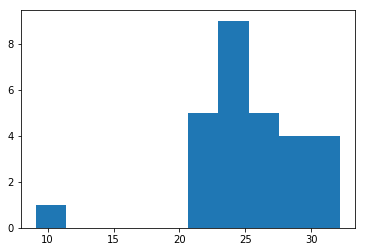

In [37]:
plt.hist([float(i['KEGGassembledDisp']) for i in ph_archaea_records])

(array([  39.,  333.,  972.,  271.,    9.,    0.,    0.,    0.,    0.,    1.]),
 array([   3.18 ,   12.862,   22.544,   32.226,   41.908,   51.59 ,
          61.272,   70.954,   80.636,   90.318,  100.   ]),
 <a list of 10 Patch objects>)

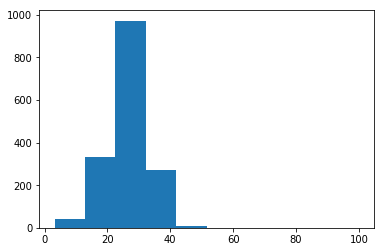

In [38]:
plt.hist([float(i['KEGGassembledDisp']) for i in archaea_metadata["records"]])

#### % of coding bases in assembled genomes

In [42]:
[i['CodingBaseCountassembled125'] for i in ph_archaea_records]

[u'93.38',
 u'92.73',
 u'82.39',
 u'86.59',
 u'86.05',
 u'89.25',
 u'81.21',
 u'87.27',
 u'86.29',
 u'95.38',
 u'82.65',
 u'82.8',
 u'83.08',
 u'84.55',
 u'84.22',
 u'90.58',
 u'94.82',
 u'82.31',
 u'90.32',
 u'91.63',
 u'94.55',
 u'85.06',
 u'91.18',
 u'86.95',
 u'92.15',
 u'90.04',
 u'83.17',
 u'82.59']

(array([ 4.,  4.,  3.,  3.,  2.,  1.,  3.,  3.,  2.,  3.]),
 array([ 81.21 ,  82.627,  84.044,  85.461,  86.878,  88.295,  89.712,
         91.129,  92.546,  93.963,  95.38 ]),
 <a list of 10 Patch objects>)

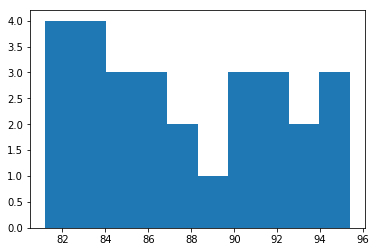

In [44]:
plt.hist([float(i['CodingBaseCountassembled125']) for i in ph_archaea_records])

(array([   1.,    0.,    0.,    0.,    0.,    0.,    2.,  115.,  607.,  900.]),
 array([  0.84 ,  10.539,  20.238,  29.937,  39.636,  49.335,  59.034,
         68.733,  78.432,  88.131,  97.83 ]),
 <a list of 10 Patch objects>)

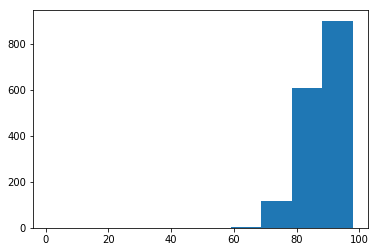

In [45]:
plt.hist([float(i['CodingBaseCountassembled125']) for i in archaea_metadata["records"]])

#### Number of archaea that each scope compound is in

In [48]:
ph_archaea_stats_dicts =[i for i in stats_dicts if i["domain"]=="archaea"]

In [ ]:
[i["scope_compounds"] for i in ph_archaea_stats_dicts]

In [54]:
all_ph_archaea_scope_compounds = [c for i in ph_archaea_stats_dicts for c in i["scope_compounds"]]

In [55]:
len(all_ph_archaea_scope_compounds)

23850

In [60]:
len(collections.Counter(all_ph_archaea_scope_compounds))

1610

In [61]:
len(set(all_ph_archaea_scope_compounds))

1610

(array([ 280.,  154.,   79.,   43.,  204.,  158.,  119.,  140.,  149.,  284.]),
 array([  1. ,   3.7,   6.4,   9.1,  11.8,  14.5,  17.2,  19.9,  22.6,
         25.3,  28. ]),
 <a list of 10 Patch objects>)

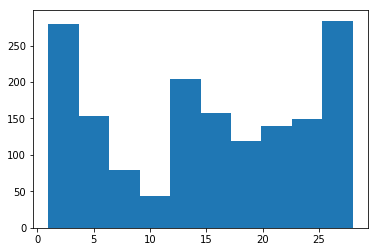

In [59]:
## y-axis: number of unique compounds
## x-axis: number of ph archaea that have y-unique compounds.
## eg. there are approx 275 compounds that only show up in 1 species (left side of plot)
## and approx 50 compounds that only show up in 10 species (low point of histogram)
plt.hist(collections.Counter(all_ph_archaea_scope_compounds).values())

#### molecular weight of compounds

In [62]:
kegg_compounds = load_json("../kegg/2018-09-25/compound.json")

In [77]:
kegg_masses = dict()
cdir = "../kegg/2018-09-25/compound/"
for fname in os.listdir(cdir):
    cjson = load_json(cdir+fname)
    kegg_masses[cjson[0]['entry_id']] = float(cjson[0]['exact_mass'])

In [79]:
len(kegg_masses)

18181

In [80]:
kegg_masses_ph_archaea_only = dict()
for i in all_ph_archaea_scope_compounds:
    kegg_masses_ph_archaea_only[i] = kegg_masses[i]

In [81]:
len(kegg_masses_ph_archaea_only)

1610

In [82]:
kegg_masses_ph_archaea_only

{u'C01028': 162.1004,
 u'C04506': 0.0,
 u'C01755': 58.983,
 u'C01024': 854.2858,
 u'C04500': 0.0,
 u'C04501': 301.0563,
 u'C04874': 255.0968,
 u'C16389': 1121.3711,
 u'C16684': 0.0,
 u'C16685': 0.0,
 u'C16688': 422.0825,
 u'C00555': 87.0684,
 u'C02130': 384.1268,
 u'C02133': 0.0,
 u'C02137': 150.0317,
 u'C07213': 122.0732,
 u'C09820': 971.1575,
 u'C14463': 146.0579,
 u'C01330': 22.9898,
 u'C00552': 150.0164,
 u'C01335': 0.0,
 u'C05839': 326.1002,
 u'C05838': 164.0473,
 u'C06232': 163.9007,
 u'C05357': 0.0,
 u'C01935': 0.0,
 u'C05909': 322.0689,
 u'C01931': 0.0,
 u'C01240': 0.0,
 u'C02225': 206.0427,
 u'C02226': 130.0266,
 u'C02593': 977.3136,
 u'C18802': 905.3056,
 u'C17560': 0.0,
 u'C17561': 0.0,
 u'C03069': 849.1571,
 u'C06585': 222.0448,
 u'C06586': 220.0291,
 u'C03263': 660.3159,
 u'C02047': 0.0,
 u'C06567': 0.0,
 u'C03082': 213.0038,
 u'C06560': 145.0155,
 u'C16361': 210.0753,
 u'C16362': 200.0909,
 u'C04272': 134.0579,
 u'C08325': 457.1584,
 u'C03402': 0.0,
 u'C17962': 167.0347,


In [83]:
len([i for i in kegg_masses_ph_archaea_only if kegg_masses_ph_archaea_only[i]==0.0])

361

In [93]:
tups = [("c",90),("a",119),("f",80)]

In [97]:
sorted(tups, key=lambda x: x[1], reverse=True)

[('a', 119), ('c', 90), ('f', 80)]

In [98]:
xs

[9, 5, 4, 3, 3, 2, 1]

In [103]:
xs.pop(0)

9

In [107]:
stats_dicts[0]['scope_compounds']

[u'C01832',
 u'C00016',
 u'C20518',
 u'C00028',
 u'C00299',
 u'C00009',
 u'C00002',
 u'C01346',
 u'C00506',
 u'C00026',
 u'C00065',
 u'C16636',
 u'C03826',
 u'C00100',
 u'C00048',
 u'C05431',
 u'C00030',
 u'C00007',
 u'C07645',
 u'C00004',
 u'C00080',
 u'C00139',
 u'C00071',
 u'C00001',
 u'C03798',
 u'C00258',
 u'C00003',
 u'C00014',
 u'C00201',
 u'C03023',
 u'C00343',
 u'C14818',
 u'C00288',
 u'C06055',
 u'C03090',
 u'C00013',
 u'C00025',
 u'C05125',
 u'C15972',
 u'C01103',
 u'C00103',
 u'C01185',
 u'C00011',
 u'C06507',
 u'C04122',
 u'C02923',
 u'C00957',
 u'C00094',
 u'C03880',
 u'C02489',
 u'C00006',
 u'C00455',
 u'C00511',
 u'C00117',
 u'C03005',
 u'C00010',
 u'C00353',
 u'C04590',
 u'C00097',
 u'C03078',
 u'C02670',
 u'C02133',
 u'C00024',
 u'C00263',
 u'C19675',
 u'C16468',
 u'C00019',
 u'C20663',
 u'C16244',
 u'C00064',
 u'C15673',
 u'C00044',
 u'C03273',
 u'C03794',
 u'C21299',
 u'C00493',
 u'C06002',
 u'C00459',
 u'C11945',
 u'C01672',
 u'C15853',
 u'C07281',
 u'C00131',
 u'C

In [131]:
all_ph_archaea_scope_compounds

[u'C01832',
 u'C00016',
 u'C20518',
 u'C00028',
 u'C00299',
 u'C00009',
 u'C00002',
 u'C01346',
 u'C00506',
 u'C00026',
 u'C00065',
 u'C16636',
 u'C03826',
 u'C00100',
 u'C00048',
 u'C05431',
 u'C00030',
 u'C00007',
 u'C07645',
 u'C00004',
 u'C00080',
 u'C00139',
 u'C00071',
 u'C00001',
 u'C03798',
 u'C00258',
 u'C00003',
 u'C00014',
 u'C00201',
 u'C03023',
 u'C00343',
 u'C14818',
 u'C00288',
 u'C06055',
 u'C03090',
 u'C00013',
 u'C00025',
 u'C05125',
 u'C15972',
 u'C01103',
 u'C00103',
 u'C01185',
 u'C00011',
 u'C06507',
 u'C04122',
 u'C02923',
 u'C00957',
 u'C00094',
 u'C03880',
 u'C02489',
 u'C00006',
 u'C00455',
 u'C00511',
 u'C00117',
 u'C03005',
 u'C00010',
 u'C00353',
 u'C04590',
 u'C00097',
 u'C03078',
 u'C02670',
 u'C02133',
 u'C00024',
 u'C00263',
 u'C19675',
 u'C16468',
 u'C00019',
 u'C20663',
 u'C16244',
 u'C00064',
 u'C15673',
 u'C00044',
 u'C03273',
 u'C03794',
 u'C21299',
 u'C00493',
 u'C06002',
 u'C00459',
 u'C11945',
 u'C01672',
 u'C15853',
 u'C07281',
 u'C00131',
 u'C

In [113]:
collections.Counter([i['EcosystemCategory'] for i in ph_archaea_records])

Counter({u'Aquatic': 24, u'Terrestrial': 1, u'Wastewater': 1, u'zzz': 2})

In [116]:
collections.Counter([i['Habitat'] for i in ph_archaea_records])

Counter({u'Aquatic, Fresh water': 4,
         u'Aquatic, Fresh water, Saline water': 1,
         u'Aquatic, Fresh water, Sediment': 4,
         u'Aquatic, Fresh water, Soil': 1,
         u'Aquatic, Hot spring, Hydrothermal vent': 1,
         u'Aquatic, Hot spring, Hydrothermal vent, Marine': 1,
         u'Aquatic, Soda lakes': 1,
         u'Fresh water, Aquatic': 1,
         u'Hot spring': 1,
         u'Marine, Sediment': 1,
         u'hot spring sediment': 11,
         u'zzz': 1})

In [122]:
collections.Counter([i['Habitat'] for i in ph_bacteria_records])

Counter({u'Air': 3,
         u'Alkaline water': 1,
         u'Alkaline water, Soda lake': 1,
         u'Aquatic': 7,
         u'Aquatic, Deep sea, Marine': 1,
         u'Aquatic, Deep sea, Marine, Sediment': 4,
         u'Aquatic, Fresh water': 11,
         u'Aquatic, Fresh water, Host': 1,
         u'Aquatic, Fresh water, Hot spring': 2,
         u'Aquatic, Fresh water, Lake': 2,
         u'Aquatic, Fresh water, Lake, Soda lakes': 1,
         u'Aquatic, Fresh water, Marine': 1,
         u'Aquatic, Fresh water, Mud': 1,
         u'Aquatic, Fresh water, Sediment': 3,
         u'Aquatic, Fresh water, Sediment, Soda lakes': 3,
         u'Aquatic, Fresh water, Soil': 1,
         u'Aquatic, Host': 2,
         u'Aquatic, Host, Insect': 1,
         u'Aquatic, Host, Marine': 5,
         u'Aquatic, Hot spring': 5,
         u'Aquatic, Hot spring, Sediment': 2,
         u'Aquatic, Hypersaline lakes': 1,
         u'Aquatic, Marine': 1,
         u'Aquatic, Marine, Sea water': 14,
         u'Aquatic

In [127]:
bact_habitat_counter = collections.Counter([i['Habitat'] for i in ph_bacteria_records])
n_aquatic = 0
for i in bact_habitat_counter:
    if 'Aquatic' in i:
        n_aquatic+= bact_habitat_counter[i]

In [130]:
sum(bact_habitat_counter.values())

266

In [129]:
n_aquatic

101

In [119]:
collections.Counter([i['EnergySource'] for i in ph_archaea_records])

Counter({u'Chemoorganotroph': 10,
         u'Heterotroph': 1,
         u'Organotroph': 2,
         u'zzz': 15})

In [118]:
collections.Counter([i['EnergySource'] for i in ph_bacteria_records])

Counter({u'Chemoautotroph': 1,
         u'Chemoheterotroph': 20,
         u'Chemoheterotroph, Photoautotroph': 1,
         u'Chemolithoautotroph': 1,
         u'Chemolithotroph': 1,
         u'Chemoorganoheterotroph': 2,
         u'Chemoorganotroph': 27,
         u'Chemoorganotroph, Heterotroph': 2,
         u'Heterotroph': 31,
         u'Lithoheterotroph': 1,
         u'Methylotroph': 1,
         u'Phototroph': 1,
         u'zzz': 177})

In [115]:
bacteria_metadata["records"][0].keys()

[u'SalinityConcentration',
 u'pHDisp',
 u'GenomeNameSampleName',
 u'HabitatDisp',
 u'GenomeNameSampleNameDisp',
 u'pH',
 u'GenomeSizeassembledDisp',
 u'StudyNameDisp',
 u'IMGGenomeIDDisp',
 u'SequencingCenterDisp',
 u'DomainDisp',
 u'SalinityConcentrationDisp',
 u'SequencingStatus',
 u'GeneCountassembled',
 u'SalinityDisp',
 u'Salinity',
 u'SequencingStatusDisp',
 u'GeneCountassembledDisp',
 u'Domain',
 u'EnergySourceDisp',
 u'_img_yuirow_id',
 u'Habitat',
 u'EnergySource',
 u'SequencingCenter',
 u'GenomeSizeassembled',
 u'StudyName',
 u'IMGGenomeID',
 u'Select']

In [23]:
archaea_metadata["records"][0].keys()

[u'Enzymeassembled',
 u'IMGProductAssignment',
 u'MetaCycCountassembled',
 u'ContactNameDisp',
 u'BiosyntheticClusterGeneassembledDisp',
 u'ProportalWOASalinity',
 u'GenomeProperty',
 u'SampleBodySubsiteDisp',
 u'SpecificEcosystem',
 u'COGClusterCountassembledDisp',
 u'RevisedCountDisp',
 u'GOLDSequencingProjectIDDisp',
 u'SampleBodySiteDisp',
 u'DomainDisp',
 u'Sporulation',
 u'UncharCountDisp',
 u'FundingProgram',
 u'PfamClusterCountassembledDisp',
 u'GOLDAnalysisProjectID',
 u'ITSSPIDDisp',
 u'Comments',
 u'MetabolismDisp',
 u'RNAassembled',
 u'SporulationDisp',
 u'SequencingCenter',
 u'JGIProjectIDITSSPIDDisp',
 u'Select',
 u'CodingBaseCountNP127',
 u'Alt2ContactEmails',
 u'KOGCountDisp',
 u'BioticRelationshipsDisp',
 u'KOGCount',
 u'CladeDisp',
 u'TransmembraneCount',
 u'MyIMGAnnotation',
 u'23SrRNACountassembledDisp',
 u'wFuncPredCountassembled',
 u'NitrateConcentrationDisp',
 u'ProportalIsolation',
 u'HostGender',
 u'ProportalOcean',
 u'NCBIProjectIDDisp',
 u'GOLDSequencingDepth

### Look at some properties of stats dicts

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  2. ,   3.2,   4.4,   5.6,   6.8,   8. ,   9.2,  10.4,  11.6,
         12.8,  14. ]),
 <a list of 10 Patch objects>)

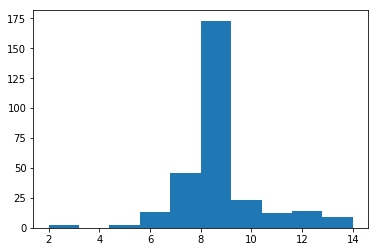

In [130]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 32. ,  34.9,  37.8,  40.7,  43.6,  46.5,  49.4,  52.3,  55.2,
         58.1,  61. ]),
 <a list of 10 Patch objects>)

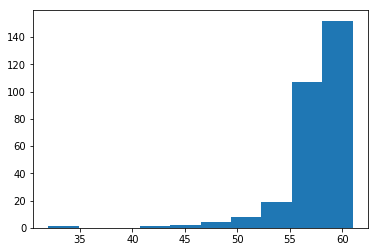

In [131]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

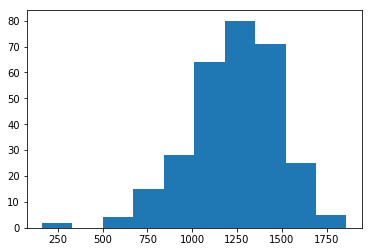

In [132]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

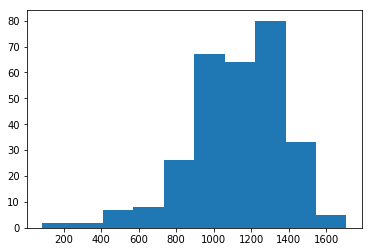

In [133]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

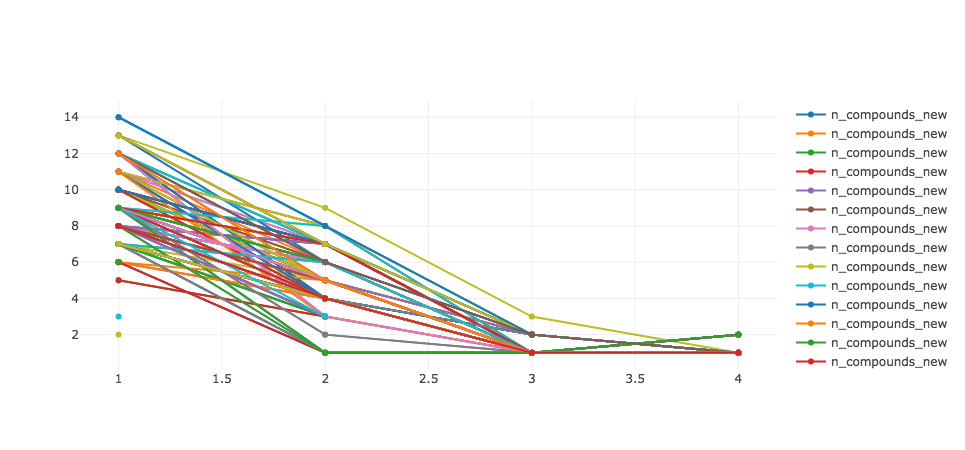

In [134]:
cool_plots_many(df,'n_compounds_new')

## Check seeds that contain phosphorous

In [135]:
INDIR = "../results/formatted/ph_edge_jsons_P/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [136]:
stats_dicts[0].keys()

['domain',
 u'scope_seeds',
 u'scope_targets',
 'org_id',
 u'scope_compounds',
 'path',
 u'scope_reactions']

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  3. ,   4.2,   5.4,   6.6,   7.8,   9. ,  10.2,  11.4,  12.6,
         13.8,  15. ]),
 <a list of 10 Patch objects>)

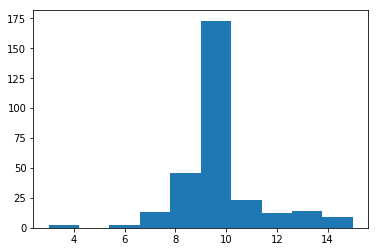

In [137]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 32. ,  34.9,  37.8,  40.7,  43.6,  46.5,  49.4,  52.3,  55.2,
         58.1,  61. ]),
 <a list of 10 Patch objects>)

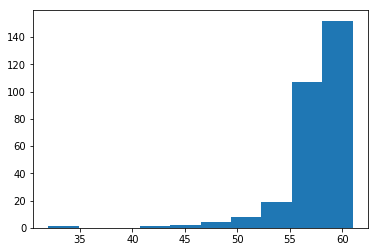

In [138]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

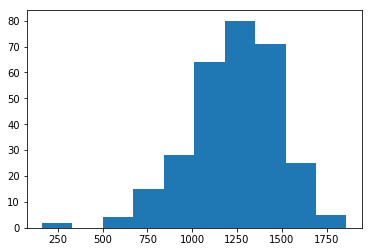

In [139]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

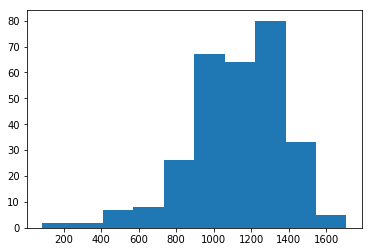

In [140]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

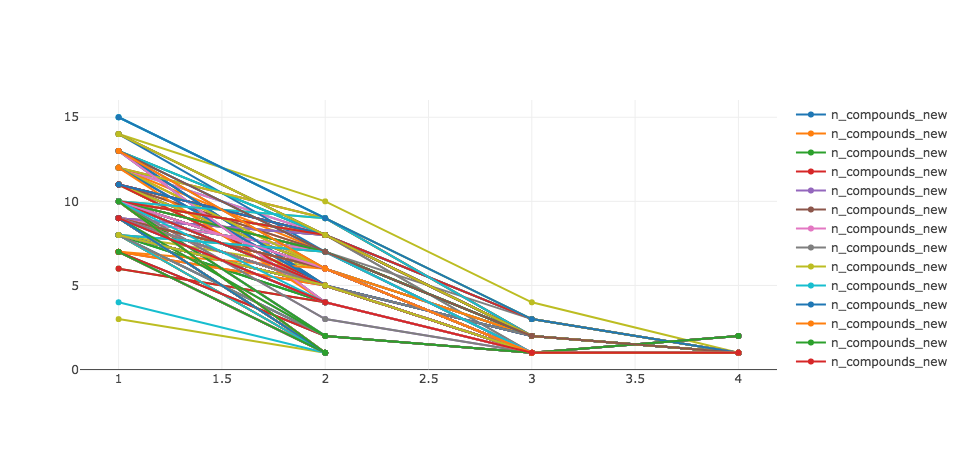

In [141]:
cool_plots_many(df,'n_compounds_new')

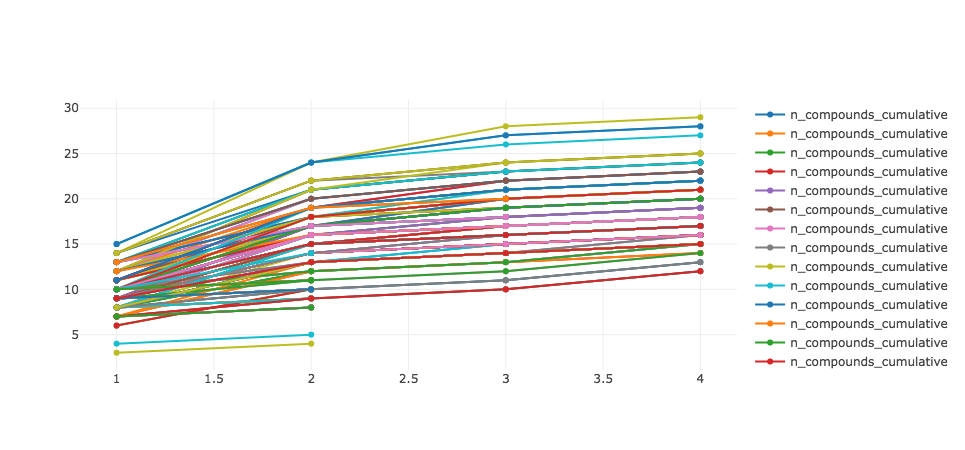

In [142]:
cool_plots_many(df,'n_compounds_cumulative')

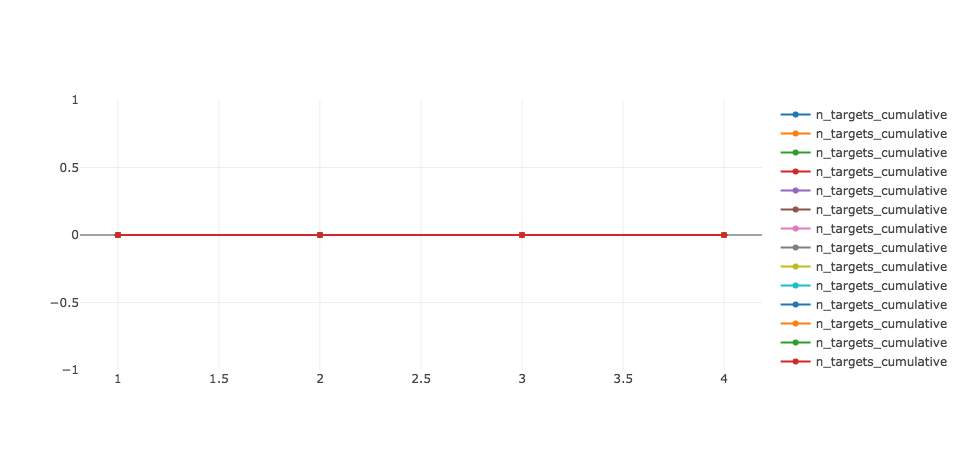

In [143]:
cool_plots_many(df,'n_targets_cumulative')

## Reversed expansions

In [144]:
INDIR = "../results/formatted/ph_edge_jsons_reversed/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [153]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00016, C00002, C00065, C00004, C00001, C0000...","[C00075, C00006, C00001, C00360, C00003, C0000...","[R00782, R00243, R00093, R10348, R00114, R0075...","[R00236, R00114, R00516, R02094, R00963, R0015...",[C00001],[C00001],56,56,73,73,1,1,2506520044,archaea
2,"[C00016, C00299, C00009, C00002, C00026, C0006...","[C00299, C00009, C00026, C00048, C00080, C0001...","[R01876, R02331, R00143, R00253, R00782, R0024...","[R01876, R02331, R00143, R00253, R02097, R1009...","[C00001, C00014, C00011, C00283]","[C00014, C00011, C00283]",109,53,196,123,4,3,2506520044,archaea
3,"[C00016, C00299, C00009, C00002, C01346, C0002...","[C01346, C14818, C00288, C01103, C00957, C0045...","[R01876, R02331, R09186, R01388, R00143, R0107...","[R09186, R01388, R01072, R01870, R02323, R0104...","[C00001, C00014, C00011, C00067, C00469, C00283]","[C00067, C00469]",192,83,287,91,6,2,2506520044,archaea
4,"[C00016, C00299, C00009, C00002, C01346, C0002...","[C03826, C00258, C03090, C01185, C00117, C0026...","[R01876, R02331, R09186, R01388, R00143, R0107...","[R03348, R01776, R01083, R01395, R05605, R0224...","[C00001, C00014, C00011, C00067, C00469, C0028...",[C00132],249,57,350,63,7,1,2506520044,archaea
5,"[C00016, C00299, C00009, C00002, C01346, C0002...","[C00007, C03794, C00898, C00081, C01563, C0444...","[R01876, R02331, R09186, R01388, R00143, R0007...","[R00078, R01859, R06180, R00970, R07456, R0694...","[C00001, C00014, C00011, C00067, C00469, C0028...",[],300,51,404,54,7,0,2506520044,archaea


(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 33. ,  35.9,  38.8,  41.7,  44.6,  47.5,  50.4,  53.3,  56.2,
         59.1,  62. ]),
 <a list of 10 Patch objects>)

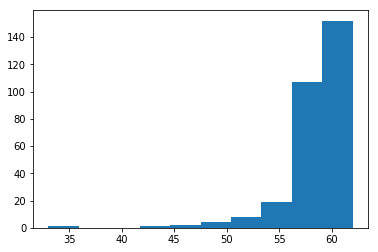

In [145]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  2. ,   3.2,   4.4,   5.6,   6.8,   8. ,   9.2,  10.4,  11.6,
         12.8,  14. ]),
 <a list of 10 Patch objects>)

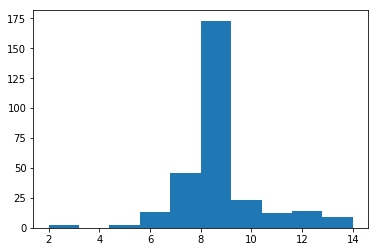

In [146]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

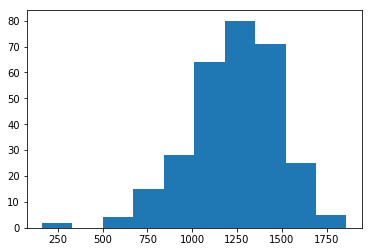

In [147]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

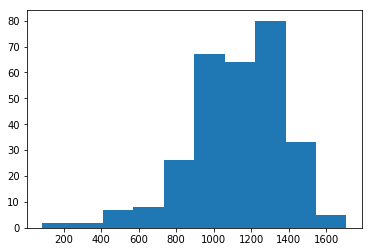

In [148]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

In [152]:
# cool_plots_many(df,'n_compounds_new')

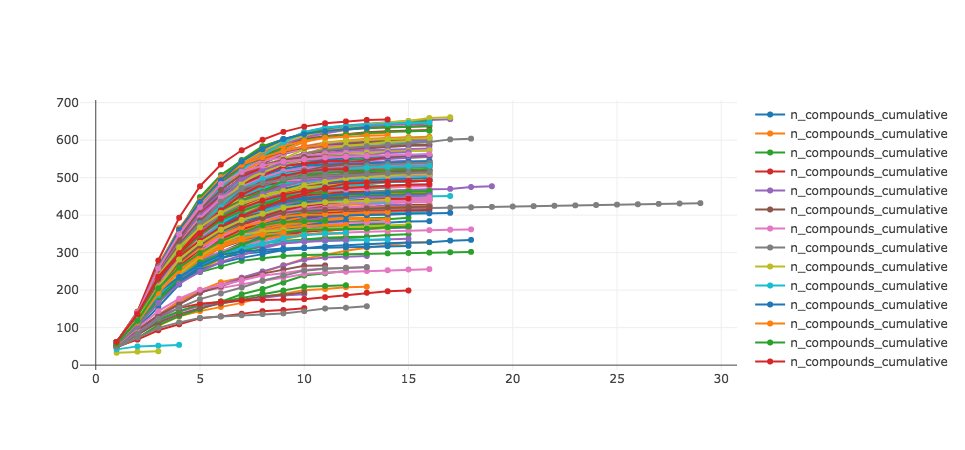

In [150]:
cool_plots_many(df,'n_compounds_cumulative')

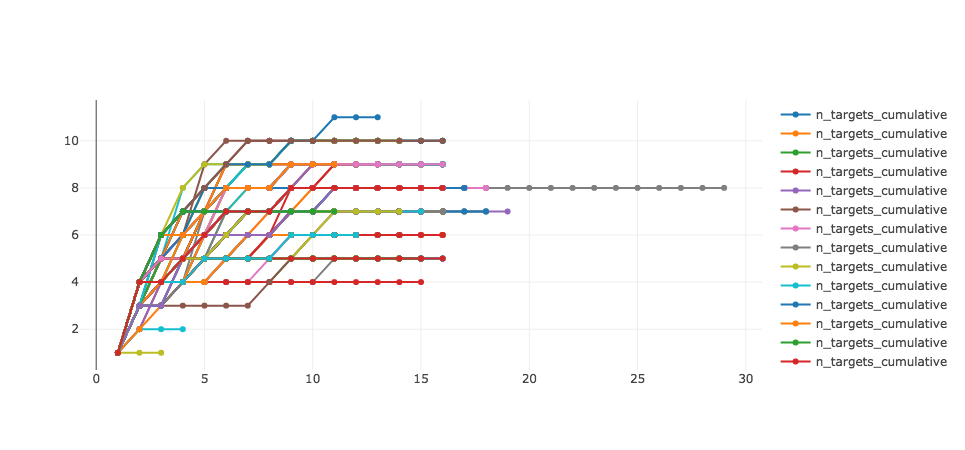

In [151]:
cool_plots_many(df,'n_targets_cumulative')

## - This lets me know that I need to start with targets and work backwards to try and figure out seeds necessary to produce those targets.

In [ ]:
possible_scope_targets = {"C00002": "ATP",
"C00003": "NAD+",
"C00004": "NADH",
"C00005": "NADPH",
"C00006": "NADP+",
"C00008": "ADP",
"C00015": "UDP",
"C00016": "FAD",
"C00020": "AMP",
"C00024": "Acetyl-CoA",
"C00025": "L-Glutamate",
"C00035": "GDP",
"C00037": "Glycine",
"C00041": "L-Alanine",
"C00043": "UDP-N-acetyl-D-glucosamine",
"C00044": "GTP",
"C00047": "L-Lysine",
"C00049": "L-Aspartate",
"C00054": "Adenosine 3',5'-bisphosphate",
"C00055": "CMP",
"C00062": "L-Arginine",
"C00063": "CTP",
"C00064": "L-Glutamine",
"C00065": "L-Serine",
"C00073": "L-Methionine",
"C00075": "UTP",
"C00078": "L-Tryptophan",
"C00079": "L-Phenylalanine",
"C00082": "L-Tyrosine",
"C00097": "L-Cysteine",
"C00105": "UMP",
"C00112": "CDP",
"C00116": "Glycerol",
"C00123": "L-Leucine",
"C00131": "dATP",
"C00135": "L-Histidine",
"C00144": "GMP",
"C00148": "L-Proline",
"C00152": "L-Asparagine",
"C00183": "L-Valine",
"C00188": "L-Threonine",
"C00234": "10-Formyltetrahydrofolate",
"C00239": "dCMP",
"C00249": "Hexadecanoic acid",
"C00255": "Riboflavin",
"C00286": "dGTP",
"C00350": "Phosphatidylethanolamine",
"C00360": "dAMP",
"C00362": "dGMP",
"C00364": "dTMP",
"C00399": "Ubiquinone",
"C00407": "L-Isoleucine",
"C00458": "dCTP",
"C00459": "dTTP",
"C00641": "1,2-Diacyl-sn-glycerol",
"C00748": "Siroheme",
"C01050": "UDP-N-acetylmuramate",
"C05764": "Hexadecanoyl-[acp]",
"C05890": "Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L",
"C05894": "Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L",
"C05899": "Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L",
"C05980": "Cardiolipin",
"C06040": "Diglucosyl-diacylglycerol",
"C15672": "Heme O",
"C16221": "(2E)-Octadecenoyl-[acp]"}

## Using all KEGGs reactions

In [116]:
def read_formatted_json_single(INDIR):
    generation_dfs = []
    stats_dicts = []
    
#     for domain in os.listdir(INDIR):
    for fname in glob.glob(INDIR+"*.json"):

        org_id = os.path.basename(fname).strip(".json")

        with open(fname) as f:
            datajson = json.load(f)

        datajson["stats"]["org_id"] = org_id
#         datajson["stats"]["domain"] = domain
        datajson["stats"]["path"] = fname

        stats_dicts.append(datajson["stats"])
        generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

### Transpose etc.

In [118]:
def twist_dfs(df_list):
    twisted_dfs = []
    for df in df_list:
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()   
        twisted_dfs.append(df)
    return twisted_dfs

### Add `n` columns

In [119]:
def add_n_to_cols_original(df_list):
    for df in df_list:
        original_columns = df.columns
        for col in original_columns:
            df["n_"+col] = df[col].str.len() 
    return df_list

### Add domain and org_id

In [147]:
def add_domain_and_orgid(df_list,stats_dicts):
    for i,df in enumerate(df_list):
#         df['seed'] = stats_dicts[i]["seed"]
        df['org_id'] = stats_dicts[i]["org_id"]
#         df['domain'] = stats_dicts[i]["domain"]
    return df_list

### Add tags if desired

In [125]:
def add_tags(df_list,cpds_to_tag):
    for df in df_list:
        df['tags'] = df['compounds_new'].apply(lambda x: [cpd for cpd in cpds_to_tag if cpd in x])
    return df_list

### Load metadata

In [126]:
def load_json(fname):
    with open(fname) as f:
        return json.load(f)

In [148]:
INDIR = "../results/formatted/kegg_edge_json/"

generation_dfs, stats_dicts = read_formatted_json_single(INDIR)
# print len(generation_dfs)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols_original(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
keggdf = generation_dfs[0]

In [149]:
len(stats_dicts[0])

6

In [150]:
stats_dicts[0].keys()

[u'scope_seeds',
 u'scope_targets',
 'org_id',
 u'scope_compounds',
 'path',
 u'scope_reactions']

In [161]:
keggdf.iloc[0]['compounds_cumulative']

[u'C00001',
 u'C01326',
 u'C00132',
 u'C00067',
 u'C00014',
 u'C11505',
 u'C01407',
 u'C00011',
 u'C00697',
 u'C00282',
 u'C00283',
 u'C06547',
 u'C00237',
 u'C00469',
 u'C20783',
 u'C01438',
 u'C06548',
 u'C01548']

In [152]:
keggdf.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id
1,"[C00001, C01326, C00132, C00067, C00014, C1150...","[C06547, C20783, C01548, C00014, C00011, C0006...","[R10092, R05539, R09139, R00067, R00132, R0235...","[R10535, R10079, R10092, R00131, R09139, R0538...",[],[],18,18,23,23,0,0,reaction_edge
2,"[C00001, C00080, C00007, C00026, C01326, C0013...","[C00080, C00007, C00026, C00288, C05359, C0002...","[R10092, R00608, R05539, R00279, R09139, R0006...","[R00608, R00279, R03546, R09144, R07803, R0478...",[],[],41,23,59,36,0,0,reaction_edge
3,"[C00001, C00080, C00007, C00026, C00048, C0132...","[C00048, C00025, C00704, C00022, C00222, C0021...","[R00782, R10092, R00608, R00258, R05539, R0027...","[R00782, R00258, R00475, R00008, R01874, R0537...",[C00025],[C00025],67,26,147,88,1,1,reaction_edge
4,"[C00001, C00080, C00007, C00026, C00048, C0132...","[C00036, C00546, C00097, C00037, C00065, C0006...","[R00340, R00363, R00782, R10092, R10178, R0060...","[R00340, R00363, R10178, R02914, R09648, R0156...","[C00025, C00097, C00037, C00065, C00064, C00041]","[C00097, C00037, C00065, C00064, C00041]",146,79,288,141,6,5,reaction_edge
5,"[C00001, C00080, C00007, C02107, C00026, C0382...","[C02107, C03826, C00383, C02091, C00108, C0095...","[R00340, R09186, R10908, R03106, R03551, R0369...","[R09186, R10908, R03106, R03551, R03694, R0696...","[C00025, C00097, C00037, C00065, C00064, C0004...","[C00049, C00188]",244,98,393,105,8,2,reaction_edge


In [153]:
keggdf.tail()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id
40,"[C01832, C00016, C00422, C00001, C17224, C0002...","[C19586, C16756, C16339, C19585, C19595]","[R03857, R02250, R08640, R00340, R02433, R0108...","[R09409, R09410, R09406, R07902]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],4871,5,6853,4,61,0,reaction_edge
41,"[C01832, C00016, C00422, C00001, C17224, C0002...","[C19588, C11278, C19594, C16317]","[R03857, R02250, R08640, R00340, R02433, R0108...",[R09411],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],4875,4,6854,1,61,0,reaction_edge
42,"[C01832, C00016, C00422, C00001, C17224, C0002...",[C19589],"[R03857, R02250, R08640, R00340, R02433, R0108...","[R09413, R09412]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],4876,1,6856,2,61,0,reaction_edge
43,"[C01832, C00016, C00422, C00001, C17224, C0002...","[C19592, C19591]","[R03857, R02250, R08640, R00340, R02433, R0108...","[R09415, R09414]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],4878,2,6858,2,61,0,reaction_edge
44,"[C01832, C00016, C00422, C00001, C17224, C0002...",[C19590],"[R03857, R02250, R08640, R00340, R02433, R0108...",[],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],4879,1,6858,0,61,0,reaction_edge


(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 17.5,  17.6,  17.7,  17.8,  17.9,  18. ,  18.1,  18.2,  18.3,
         18.4,  18.5]),
 <a list of 10 Patch objects>)

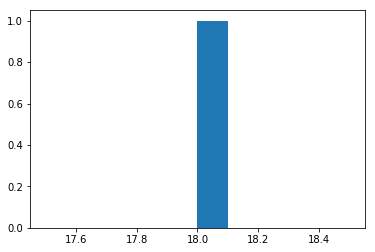

In [154]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 62.5,  62.6,  62.7,  62.8,  62.9,  63. ,  63.1,  63.2,  63.3,
         63.4,  63.5]),
 <a list of 10 Patch objects>)

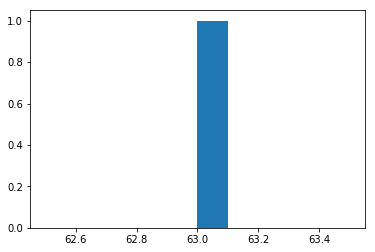

In [155]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 8278.5,  8278.6,  8278.7,  8278.8,  8278.9,  8279. ,  8279.1,
         8279.2,  8279.3,  8279.4,  8279.5]),
 <a list of 10 Patch objects>)

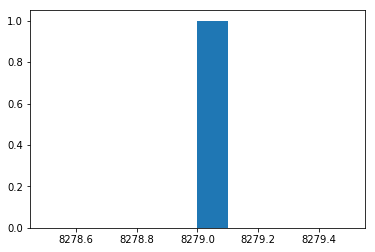

In [156]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 10286.5,  10286.6,  10286.7,  10286.8,  10286.9,  10287. ,
         10287.1,  10287.2,  10287.3,  10287.4,  10287.5]),
 <a list of 10 Patch objects>)

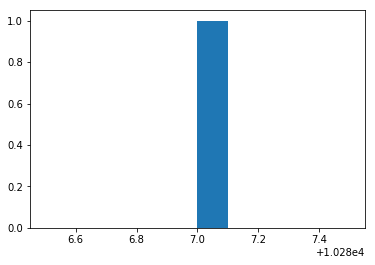

In [157]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

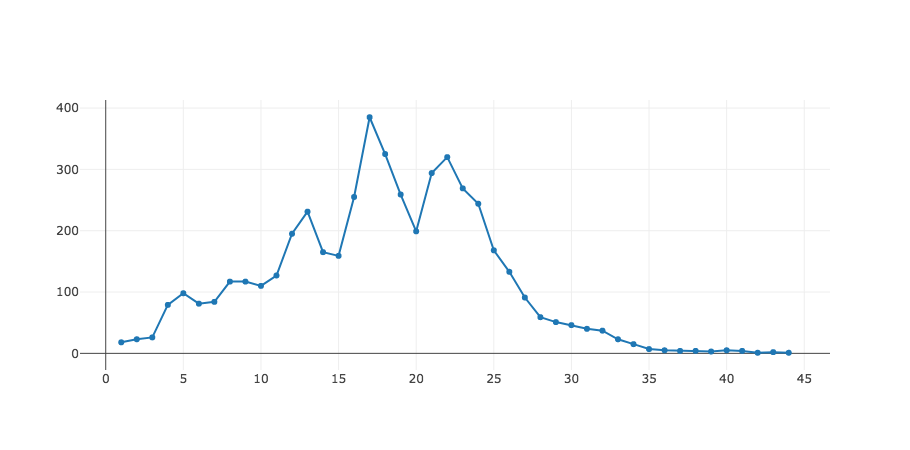

In [158]:
cool_plots_many(keggdf,'n_compounds_new')

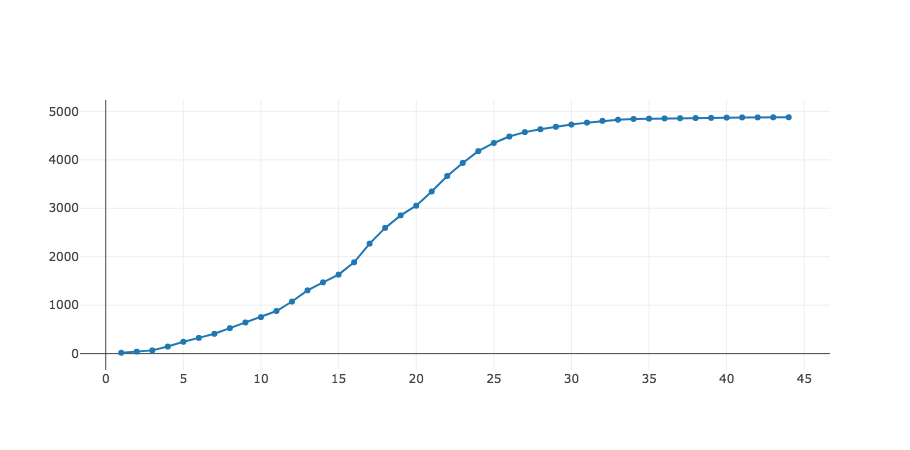

In [159]:
cool_plots_many(keggdf,'n_compounds_cumulative')

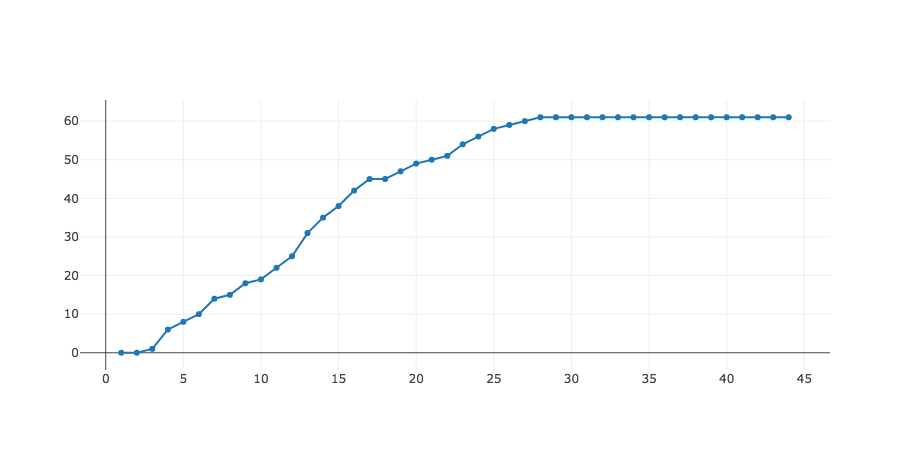

In [160]:
cool_plots_many(keggdf,'n_targets_cumulative')

### Check if the targets columns were erroneous

#### Add map pathway data too?

#### Adding target data could be done post-processing as well

In [168]:
set(datajson["stats"]["scope_targets"])&set(generations["compounds_cumulative"][25])

set()

In [169]:
generations['compounds_cumulative'].apply(lambda x: [cpd for cpd in datajson["stats"]["scope_targets"] if cpd in x])


1     []
2     []
3     []
4     []
5     []
6     []
7     []
8     []
9     []
10    []
11    []
12    []
13    []
14    []
15    []
16    []
17    []
18    []
19    []
20    []
21    []
22    []
23    []
24    []
25    []
Name: compounds_cumulative, dtype: object

#### They don't appear to be.

## Plot

In [143]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        text=df['tags'],
        textposition='top center'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

In [41]:
df["org_id"].unique()

array(['2506520044', '2506783009', '2517287024', '2529293002',
       '2529293211', '2531839260', '2554235474', '2554235476',
       '2554235477', '2554235490', '2554235497', '2718217646',
       '2718217664', '2718217665', '2718217666', '2718217667',
       '2721755430', '2721755431', '2721755892', '2721755895',
       '2724679803', '2728369738', '2739367758', '2740891997', '638154515',
       '644736411', '644736412', '650716079', '2515154133', '2515154138',
       '2515154140', '2515154141', '2515154152', '2517572146',
       '2518645608', '2518645611', '2519899518', '2521172661',
       '2523533532', '2523533546', '2523533611', '2523533612',
       '2524614558', '2524614663', '2524614672', '2524614757',
       '2524614857', '2524614862', '2524614884', '2540341173',
       '2546825502', '2546825503', '2558309102', '2563366730',
       '2565956515', '2565956590', '2571042909', '2574179701',
       '2574179723', '2574180435', '2574180450', '2582580728',
       '2582581268', '258258127

In [144]:
def cool_plots_many(df,attribute):
    traces = []
    for i in df["org_id"].unique():
        
        traces.append(go.Scatter(
        x = df.loc[df["org_id"]==i].index,
        y = df.loc[df["org_id"]==i][attribute],
        mode = 'lines+markers',
        name = attribute
        ))
    plotly.offline.iplot(traces)   

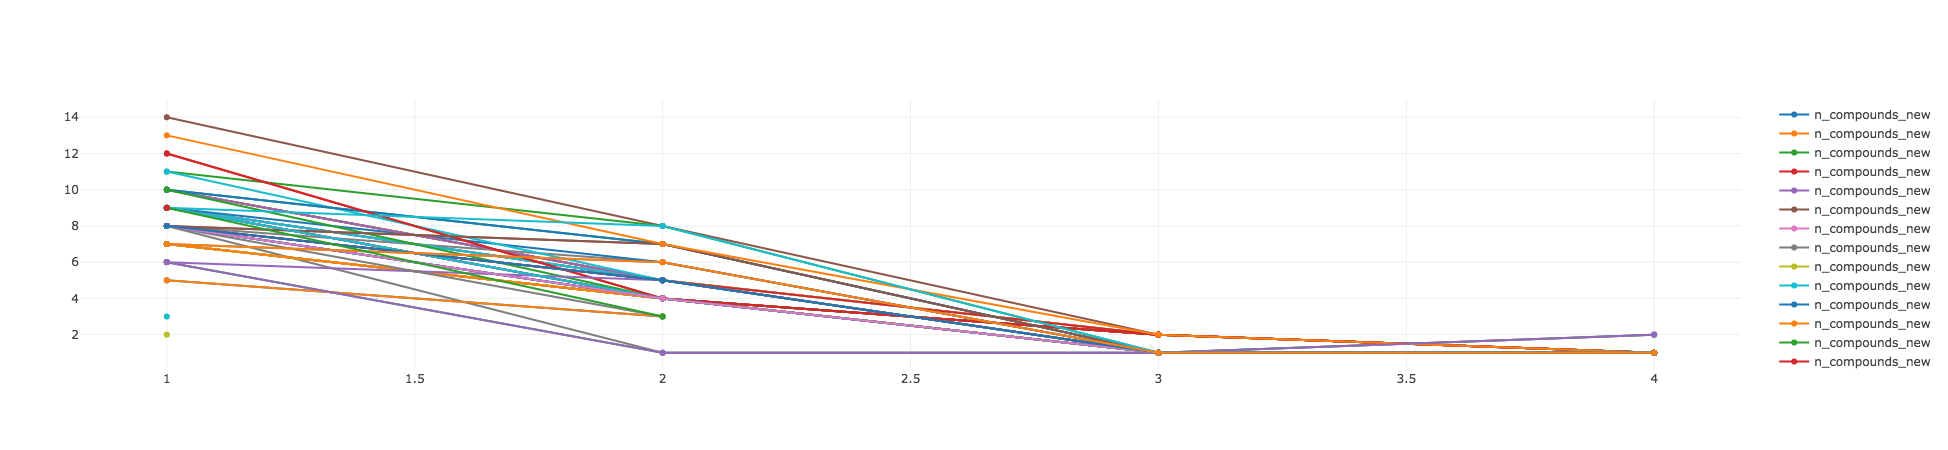

In [47]:
cool_plots_many(df,'n_compounds_new')

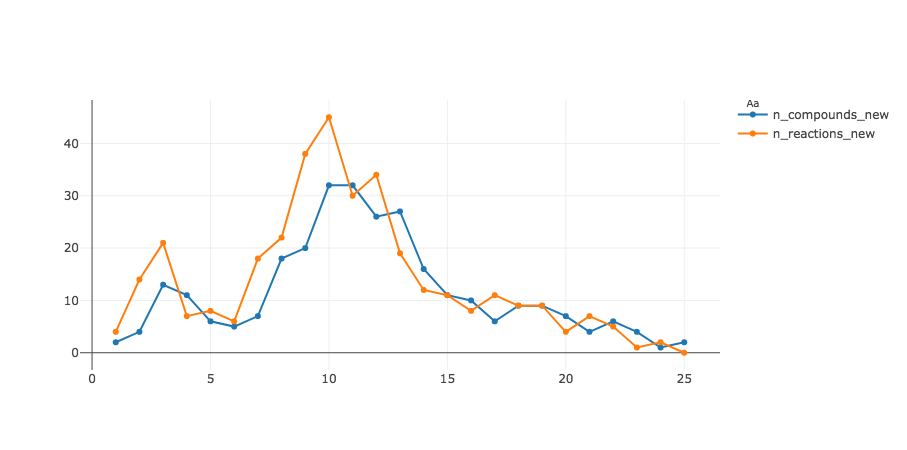

In [178]:
cool_plots(generations,'n_compounds_new','n_reactions_new')

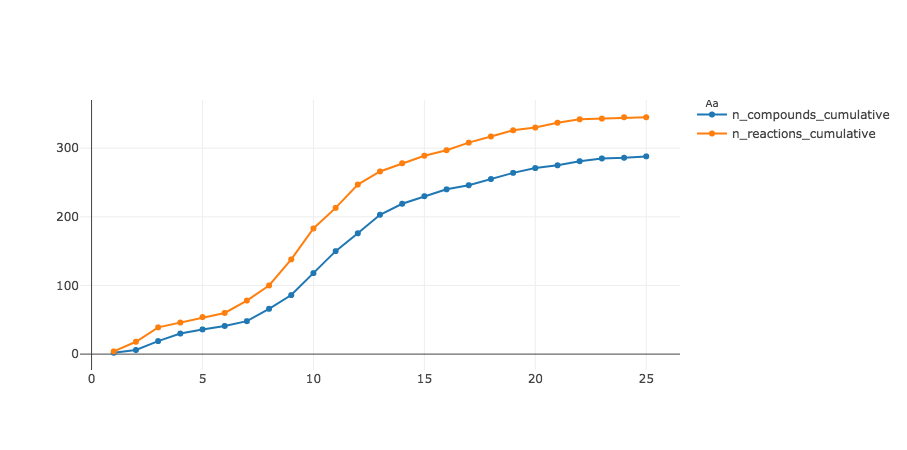

In [179]:
cool_plots(generations,'n_compounds_cumulative','n_reactions_cumulative')